## Import Libraries and the Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from IPython.core.display import HTML
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# import the data set
kchd_df = pd.read_csv('kc_house_data.csv')

## Exploratory Data Analysis and Data Set Cleaning

The following utility function simply allows us to print multiple Pandas DataDrames with "pretty" (HTML) formatting, using the Python `print()` function.

We will use it throughout this notebook whenever we wish to display a DataFrame.

For now, we use it to get an intuitive initial feel for the data set.

In [3]:
# this function allows displaying dataframes using print() with pandas "pretty" HTML formatting
#   so that multiple "pretty" displays of dataframes can be rendered "inline"
#   default behavior (without specifying a range) is identical to that of df.head()
def print_df(df, r = None):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', -1)

    if r is None:
        r = range(0, len(df))
    display(HTML(df.iloc[r].to_html()))
    display(HTML("<br>{} rows x {} columns<br><br>".format(len(r), len(df.columns))))

    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def print_df_head(df):
    print_df(df, range(0,5))    

print_df_head(kchd_df)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


We noticed right off the bat that there is a null (`NaN`) value in the very first row.

### Null Values

We officially begin our *EDA* phase by cleaning null values in the data set.

The `cols_with_null_vals` function provides a summary of all features in our data set that have null values.

In [4]:
# note that we can qualitatively retrieve this information via df.info() but this function
#   provides us with an object we can manipulate programatically, whereas df.info() just 
#   prints the display of this information
def cols_with_nulls(df):
    cols_with_null_vals = []
    summary_cols = ['name', 'index', 'dtype', 'n_null']
    for idx, col in enumerate(df.columns):
        n_null = df[col].isna().sum()
        if n_null > 0:
            cols_with_null_vals.append([col, idx, df[col].dtype, n_null])
    return pd.DataFrame(cols_with_null_vals, columns=summary_cols)

kchd_cwnv_df = cols_with_nulls(kchd_df)
display(HTML("<b>Columns with null values:</b><br><br>"))
print_df(kchd_cwnv_df)

,name,index,dtype,n_null
0,waterfront,8,float64,2376
1,view,9,float64,63
2,yr_renovated,15,float64,3842


We are working our way toward cleaning these null values.  As part of the process, after having identified which features need to be cleaned of null values, we must decide on a strategy for clearning this data.  One of the "Golden Rules" in Data Science is to avoid dropping observations from our data set at all costs and is only to be used as a last resort.  So, we decide early that we will do absolutely no dropping of any observations containing null values whatsoever.  We opt to adopt a null-value *replacement* scheme.  But, we need some heuristic to decide target values which will replace nulls that makes sense.  Understanding the data better for each of these features should suggest an acceptable replacement heuristic.

To do this, we investigate the unique values of the above features, and whether those features are *continuous* or *categorical*.

### Unique Values and Categorical "Classification"

For **continuous** data, we ought to use some aggregate function which retains the existing central tendency of the *good* values in our data set - i.e. depending on the presence of outliers or not, in the case of continuous data, we would opt to replace with the *median* or *mean* of the good values, respectively.

For **categorical** (or discrete) data, we would replace with a target discrete value or set of discrete values.  But which discrete value?  Well, this is where categorical classification comes in.  If we can determine, with a high probability, that our data is categorical, then we need to inspect the meaning of the categorical values in order to properly choose which target value should replace a null value.

So, let's take a look that now.

The following function derives a probability that a given feature is categorical or not based on the ratio of unique values to the total number of observations.  If this ratio is very low, then it suffices to say that the probability is high that the feature is likely categorical.

In [5]:
def categorical_probability(df, col, exclude_null_vals=True):
    unique_vals = df[col].unique()
    n_unique = len(unique_vals) 
    if exclude_null_vals:
        if df[col].dtype is int or df[col].dtype is float or df[col].dtype is np.float64:
            unique_vals_without_null = unique_vals[~np.isnan(unique_vals)]
        else:
            unique_vals_without_null = unique_vals[~pd.isnull(unique_vals)]
        if len(unique_vals_without_null) < len(unique_vals):
            unique_vals = unique_vals_without_null
            n_unique -= 1
    unique_vals = sorted(unique_vals)
    return (n_unique, round(1 - (n_unique/(len(df[col]))), 4), unique_vals)

And then the next function wraps the above function to get a feel of whether the probabilities that features in the data as a whole are categorical, based on some threshold.

In [6]:
def classify_as_categorical(df, threshold, exclude_null_vals=True):
    cols_classified = []
    summary_cols = ['name', 'index', 'dtype', 'n_unique', 'p_cat', 'unique_vals']
    for idx, col in enumerate(df.columns):
        n_unique, p_cat, unique_vals = categorical_probability(df, col, exclude_null_vals)
        if p_cat >= threshold:
            cols_classified.append([col, idx, df[col].dtype, n_unique, p_cat, unique_vals])
    return pd.DataFrame(cols_classified, columns=summary_cols)

Let's use it now to help determine our replacement heuristic for the **waterfront**, **view**, and **yr_renovated** features.

In [7]:
threshold = 0.0
kchd__nulls_with_cat_classification_df = classify_as_categorical(kchd_df[kchd_cwnv_df['name']], threshold)
display(HTML("<b>Columns with null values, categorical probability classification:</b><br><br>".format(threshold)))
print_df(kchd__nulls_with_cat_classification_df)

,name,index,dtype,n_unique,p_cat,unique_vals
0,waterfront,0,float64,2,0.9999,"[0.0, 1.0]"
1,view,1,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"
2,yr_renovated,2,float64,70,0.9968,"[0.0, 1934.0, 1940.0, 1944.0, 1945.0, 1946.0, 1948.0, 1950.0, 1951.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1962.0, 1963.0, 1964.0, 1965.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0]"


As you can see, the probability that each of the above features is categorical is VERY HIGH!  This is consistent with the actual list of unique values for each (excluding null).

This gives an indication that we can use a *lteral-value replacement heuristic* when we clean this data.

We can see that:
- **waterfront** behaves as a *Boolean* value and that a null value can safely be replaced by 0.0
- **view** ranges from 0 to 4: here we must decide which of these values makes most sense to use as a replacement for null
    - 0 could mean no view but
    - so that we do not disrupt the central tendency, we could use the median value, 2.0
    - on the other hand, we could be unintentionally "un-skewing" this feature if the original intent of a null value was meant to be treated equivalent to value 0.0
    - in order to counter-act undesired skewing of the data, we opt to treat null values as equivalent to value 0.0
- **yr_renovated** clearly uses 0.0 to indicate that a home has not been renovated; so we will adopt the heuristic to replace null with 0.0 in this case

Since we have decided on the heuristics for all features with null values, we can clean those features now.

The function below was written to facilitate cleaning the data based on a text-based rule definition.  See the documentation preceding the function as comments for its usage.

In [8]:
# numeric_replacement_rules should be of the form:
#    {<name_of_col>: [(outlier_val_1, 'median'|'mean'|<numeric_replacement_value>), ((outlier_val_2, 'median'|'mean'|<numeric_replacement_value>)), ... , (outlier_val_n, 'median'|'mean'|<numeric_replacement_value>)]}}
def clean_offending_values(df, numeric_replacement_rules = None, string_replacement_rules = None, friendly_name_of_df = ""):
    friendly_name = friendly_name_of_df if len(friendly_name_of_df) > 0 else "df"
    print("*** CLEANING VALUES of {}: BEGIN ***\n".format(friendly_name))
    
    has_numeric_rules = numeric_replacement_rules is not None
    has_string_rules = string_replacement_rules is not None

    if has_numeric_rules or has_string_rules:

        if has_numeric_rules:
            for col, rules in numeric_replacement_rules.items():
                print("Rules for '{}' column value replacement are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    # now handle specific replacement rule - we only have three allowable: median, mean, or a constant value
                    # if the rule is a constant value, then we can replace in place
                    data_type = type(rule)
                    replace_with_numeric_literal = data_type is int or data_type is float or data_type is np.float64
                    replace_with_median = data_type is str and rule.lower() == 'median'
                    replace_with_min = data_type is str and rule.lower() == 'min'
                    replace_with_max = data_type is str and rule.lower() == 'max'
                    replace_with_mean = data_type is str and rule.lower() == 'mean'
                    if replace_with_numeric_literal:
                        df.loc[offending_indexes, col] = rule
                        print("Replaced {} offending instances in column '{}' with literal value {}\n".format(len(offending_indexes), col, rule))
                    elif replace_with_median or replace_with_min or replace_with_max or replace_with_mean:
                        # first we need to get a subset of the rows WITHOUT any of the offending values
                        df_rows_without_outliers = df[df[col].isin(offending_vals)==False]
                        if replace_with_median or replace_with_min or replace_with_max:
                            unique_vals = sorted(df_rows_without_outliers[col].unique())
                            imputed = np.min(unique_vals) if replace_with_min else (np.min(unique_vals) if replace_with_max else np.median(unique_vals))
                            s_imputed_from = "unique values: {}".format(unique_vals)
                        else:
                            imputed = np.mean(df_rows_without_outliers[col])
                            s_imputed_from = "values from index domain:\n{}".format(df_rows_without_outliers.index) 
                        df.loc[offending_indexes, col] = imputed 
                        s_desc = "the {} of column '{}'".format(rule, col)  
                        print("{} is {} and was imputed from {}".format(s_desc.capitalize(), imputed, s_imputed_from))
                        print("Replaced {} offending instances in column '{}' with {} ({})\n".format(len(offending_indexes), col, s_desc, imputed))
                    else:
                        print("Unsupported or unknown rule: {}".format(rule))                   
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

        if has_string_rules:
            for col, rules in string_replacement_rules.items():
                print("Rules for '{}' are: {}".format(col, rules))
                # first determine if there are any offending values, which means we first need to collate said values
                offending_vals = []
                for val, rule in rules:
                    offending_vals.append(val)
                print("Looking for rows with '{}' values in {} ...".format(col, offending_vals))
                df_rows_with_outliers = df[df[col].isin(offending_vals)==True]
                if len(df_rows_with_outliers) > 0:
                    offending_indexes = df_rows_with_outliers.index
                    print("Rows with offending values occur at {}.".format(offending_indexes))
                    df.loc[offending_indexes, col] = rule
                    print("Replaced {} offending instances in column '{}' with literal value '{}'\n".format(len(offending_indexes), col, rule))                 
                else:
                    print("There are no rows that contain values of '{}' in {}!".format(col, offending_vals))

    else:
        print("Cannot clean outliers from {} since there were no replacement rules provided!".format(friendly_name))
    
    print("*** CLEANING VALUES of {}: END ***".format(friendly_name))

In [9]:
# now use the above function to clean 'waterfront' and 'yr_renovated' using lteral-value replacement
clean_offending_values(
    kchd_df
    , numeric_replacement_rules=
        {
            'waterfront': [(np.NaN, 0.0)]
            , 'view': [(np.NaN, 0.0)]
            , 'yr_renovated': [(np.NaN, 0.0)]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'waterfront' column value replacement are: [(nan, 0.0)]
Looking for rows with 'waterfront' values [nan] ...
Rows with offending values occur at Int64Index([    0,    10,    23,    40,    55,    60,    62,    66,    87,
              105,
            ...
            21544, 21545, 21550, 21562, 21567, 21578, 21582, 21586, 21587,
            21595],
           dtype='int64', length=2376).
Replaced 2376 offending instances in column 'waterfront' with literal value 0.0

Rules for 'view' column value replacement are: [(nan, 0.0)]
Looking for rows with 'view' values [nan] ...
Rows with offending values occur at Int64Index([    7,   114,   129,   205,   487,   590,   938,  1313,  1364,
             1701,  2415,  2833,  3150,  3237,  4533,  4740,  5196,  5207,
             5393,  5494,  5585,  5746,  6391,  7103,  7269,  7563,  7686,
             7716,  8047,  8066,  8279,  8575,  9405,  9853, 10023, 10174,
            1033

Having dealt with features with null values, we can now turn our attention to identifying and handling any potential outlier values.

### Deal with any potential OUTLIER (peculiar) values

We can leverage our `classify_as_categorical` function to list unique values of every feature in our data set.

If we spot any peculiar values we can then deal with them as necessary.

In [10]:
# Let's look for outliers
threshold = 0.0
kchd_cat_classification_df = classify_as_categorical(kchd_df[kchd_df.columns[1:]], threshold, False)
display(HTML("<b>Columns with potentical OUTLIER values:</b><br><br>".format(threshold)))
print_df(kchd_cat_classification_df[['name', 'dtype', 'n_unique', 'p_cat', 'unique_vals']].set_index('name'))

,dtype,n_unique,p_cat,unique_vals
name,,,,
date,object,372,0.9828,"[1/10/2015, 1/12/2015, 1/13/2015, 1/14/2015, 1/15/2015, 1/16/2015, 1/17/2015, 1/19/2015, 1/2/2015, 1/20/2015, 1/21/2015, 1/22/2015, 1/23/2015, 1/24/2015, 1/25/2015, 1/26/2015, 1/27/2015, 1/28/2015, 1/29/2015, 1/30/2015, 1/31/2015, 1/5/2015, 1/6/2015, 1/7/2015, 1/8/2015, 1/9/2015, 10/1/2014, 10/10/2014, 10/11/2014, 10/12/2014, 10/13/2014, 10/14/2014, 10/15/2014, 10/16/2014, 10/17/2014, 10/18/2014, 10/19/2014, 10/2/2014, 10/20/2014, 10/21/2014, 10/22/2014, 10/23/2014, 10/24/2014, 10/25/2014, 10/26/2014, 10/27/2014, 10/28/2014, 10/29/2014, 10/3/2014, 10/30/2014, 10/31/2014, 10/4/2014, 10/5/2014, 10/6/2014, 10/7/2014, 10/8/2014, 10/9/2014, 11/1/2014, 11/10/2014, 11/11/2014, 11/12/2014, 11/13/2014, 11/14/2014, 11/15/2014, 11/16/2014, 11/17/2014, 11/18/2014, 11/19/2014, 11/2/2014, 11/20/2014, 11/21/2014, 11/22/2014, 11/23/2014, 11/24/2014, 11/25/2014, 11/26/2014, 11/28/2014, 11/29/2014, 11/3/2014, 11/30/2014, 11/4/2014, 11/5/2014, 11/6/2014, 11/7/2014, 11/8/2014, 11/9/2014, 12/1/2014, 12/10/2014, 12/11/2014, 12/12/2014, 12/13/2014, 12/14/2014, 12/15/2014, 12/16/2014, 12/17/2014, 12/18/2014, 12/19/2014, 12/2/2014, 12/20/2014, 12/21/2014, ...]"
price,float64,3622,0.8323,"[78000.0, 80000.0, 81000.0, 82000.0, 82500.0, 83000.0, 84000.0, 85000.0, 86500.0, 89000.0, 89950.0, 90000.0, 92000.0, 95000.0, 96500.0, 99000.0, 100000.0, 102500.0, 104950.0, 105000.0, 105500.0, 106000.0, 107000.0, 109000.0, 109500.0, 110000.0, 110700.0, 111300.0, 112000.0, 114000.0, 114975.0, 115000.0, 118000.0, 118125.0, 119500.0, 119900.0, 120000.0, 120750.0, 121800.0, 122000.0, 123000.0, 123300.0, 124000.0, 124500.0, 124740.0, 125000.0, 126000.0, 126500.0, 128000.0, 128750.0, 129000.0, 129888.0, 130000.0, 132500.0, 132825.0, 133000.0, 133400.0, 134000.0, 135000.0, 135900.0, 136500.0, 137000.0, 137124.0, 137900.0, 139000.0, 139500.0, 140000.0, 141800.0, 142500.0, 143000.0, 144000.0, 144975.0, 145000.0, 145600.0, 146000.0, 146300.0, 147000.0, 147200.0, 147400.0, 147500.0, 148000.0, 148226.0, 148900.0, 149000.0, 149500.0, 149900.0, 150000.0, 150550.0, 151000.0, 151100.0, 151600.0, 152000.0, 152275.0, 152500.0, 152900.0, 153000.0, 153500.0, 153503.0, 154000.0, 154200.0, ...]"
bedrooms,int64,12,0.9994,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33]"
bathrooms,float64,29,0.9987,"[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]"
sqft_living,int64,1034,0.9521,"[370, 380, 390, 410, 420, 430, 440, 460, 470, 480, 490, 500, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 809, 810, 820, 828, 830, 833, 840, 850, 860, 870, 880, 890, 893, 894, 900, 901, 902, 910, 920, 930, 940, 950, 960, 962, 970, 980, 982, 988, 990, 998, 1000, 1008, 1010, 1020, 1030, 1040, 1048, 1050, 1060, 1061, 1068, 1070, 1072, 1076, 1078, 1080, 1084, 1088, 1090, 1092, 1095, 1100, 1108, 1110, 1120, 1122, 1129, 1130, 1131, ...]"
sqft_lot,int64,9776,0.5473,"[520, 572, 600, 609, 635, 638, 649, 651, 675, 676, 681, 683, 690, 696, 698, 700, 704, 705, 711, 713, 720, 725, 736, 740, 745, 746, 747, 750, 758, 761, 762, 772, 779, 780, 785, 798, 800, 801, 804, 806, 809, 811, 812, 813, 814, 816, 819, 825, 826, 833, 834, 835, 844, 846, 847, 850, 851, 853, 857, 858, 863, 864, 865, 867, 868, 871, 873, 874, 875, 877, 881, 885, 886, 887, 889, 890, 892, 895, 900, 902, 904, 905, 907, 912, 913, 914, 915, 916, 920, 922, 923, 925, 926, 929, 930, 932, 934, 936, 937, 940, ...]"
floors,float64,6,0.9997,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]"
waterfront,float64,2,0.9999,"[0.0, 1.0]"
view,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"


Based on the above, we do spot two specific issues:

1. based on *unique_vals* of **bedrooms**, it has an *apparent* OUTLIER value: 33.
2. based on *unique_vals* and *dtype* of **sqft_basement**, it looks like it should be a *numeric* data type but it is of type `Object` (probably stored as text).

Let's address **sqft_basement** first.

#### Converting **sqft_basement** from `string` type to `float`

Before attempting to convert the data type of **sqft_basement** to `float`, we need to replace any potential non-numeric values.

Let's find those first.

In [11]:
unique_sqft_basement = kchd_cat_classification_df[kchd_cat_classification_df['name']=='sqft_basement']['unique_vals'].values[0]
non_numeric_sqft_basement_vals = []
for idx, sqft_basement in enumerate(unique_sqft_basement):
    s_val = sqft_basement.strip()
    val = None
    try:       
        val = float(s_val)
    except:
        non_numeric_sqft_basement_vals.append(sqft_basement)

display(HTML("<b>sqft_basement</b> contains the following non-numeric values that must be replaced: {}".format(non_numeric_sqft_basement_vals)))

We opt to replace outlier value '?' of the **sqft_basement** feature with '0.0' *before* we finally convert it from `str` to `float`.

In [12]:
clean_offending_values(
    kchd_df
    , string_replacement_rules=
        {
            'sqft_basement': [('?', '0.0')]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' are: [('?', '0.0')]
Looking for rows with 'sqft_basement' values in ['?'] ...
Rows with offending values occur at Int64Index([    6,    18,    42,    79,   112,   115,   217,   309,   384,
              508,
            ...
            21236, 21248, 21356, 21357, 21365, 21442, 21447, 21473, 21519,
            21581],
           dtype='int64', length=454).
Replaced 454 offending instances in column 'sqft_basement' with literal value '0.0'

*** CLEANING VALUES of King County House Sales DF: END ***


We can now convert **sqft_basement** to type `float`:

In [13]:
kchd_df['sqft_basement']=kchd_df['sqft_basement'].astype('float64')

#### Handling **bedrooms** outliers

In [14]:
outlier_rooms = 33
kchd_with_outlier_rooms_df = kchd_df[kchd_df['bedrooms']==outlier_rooms]
kchd_with_outlier_rooms_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


Here, we see that there are home(s) that supposedly have 33 bedrooms.  Really?  I don't think so but let's try to justify this mathematically.

We see that the value of **sqft_living** is only 1620.

Let's compute the average square footage per room and compare its value to the average square footage per room of the entire data set, excluding this possible outlier observation, with **bedrooms**==33.

In [15]:
outlier_rms_avg_sqft_per_room = kchd_with_outlier_rooms_df['sqft_living']/outlier_rooms
outlier_rms_avg_sqft_per_room[outlier_rms_avg_sqft_per_room.index]

15856    49.090909
Name: sqft_living, dtype: float64

We see that, for the outlier, the average square footage per room is about 49 ft.$^2$.  That means, on average, each room is 7 ft. x 7 ft.  Is this likely?  Let's compare it to the average square footage per room of the entire data set, excluding this possible outlier observation with **bedrooms**==33.

In [16]:
avg_sqft_per_room_excluding_apparent_outlier = kchd_df['sqft_living'].sum()/kchd_df[kchd_df['bedrooms'].isin([outlier_rooms])==False]['bedrooms'].sum()
avg_sqft_per_room_excluding_apparent_outlier

617.0000686643413

We see that our outlier average square footage per room differs *drastically* from the average for the data set.  So we will impute the average (of the data set) to arrive at a reasonable value for **bedrooms** for the outlier.  Granted, this is only one observation and we have done a bit of work so far to clean this outlier value.  But, this process demonstrates the potential importance in the general case.

The formula for this is: $imputed\_outlier\_bedrooms = \frac{outlier\_sqft\_living}{avg\_sqft\_per\_room\_excluding\_apparent\_outlier}$.

In [17]:
imputed_outlier_bedrooms = kchd_with_outlier_rooms_df['sqft_living']/avg_sqft_per_room_excluding_apparent_outlier
imputed_outlier_bedrooms = imputed_outlier_bedrooms.values[0]
imputed_outlier_bedrooms

2.62560748738151

In [18]:
unique_bedrooms = sorted(list(kchd_df['bedrooms'].unique()))
unique_bedrooms.remove(outlier_rooms)
unique_bedrooms = np.array(unique_bedrooms)
print("Permissable values of bedrooms is: {}".format(unique_bedrooms))

Permissable values of bedrooms is: [ 1  2  3  4  5  6  7  8  9 10 11]


Since **imputed_outlier_bedrooms** $\in \mathbb{R}$, we need to match it to its closest neighbor in the range of *permissable* categorical values of **bedrooms**, \[1  2  3  4  5  6  7  8  9 10 11\].

In [19]:
idx_closest_br = -1
min_dist = -1
for idx, br in enumerate(unique_bedrooms):
    d = abs(imputed_outlier_bedrooms - br)
    if min_dist == -1:
        min_dist = d
        idx_closest_br = idx
    elif d < min_dist:
        min_dist = d
        idx_closest_br = idx

print("The closest (categorical) bedroom value to computed real-value {}, from {}, is {}, occuring at index {}.".format(imputed_outlier_bedrooms, unique_bedrooms, unique_bedrooms[idx_closest_br], idx_closest_br))
imputed_outlier_bedrooms = unique_bedrooms[idx_closest_br]

The closest (categorical) bedroom value to computed real-value 2.62560748738151, from [ 1  2  3  4  5  6  7  8  9 10 11], is 3, occuring at index 2.


Now we impute this value in the data set for all observations with the **bedrooms** outlier value, 33.

In [20]:
def encode_col_names(df):
    return df.rename(columns=lambda x: x.replace(" ", "").replace(",", "__").replace(".", "_").replace("(", "e").replace("]", "i"))

In [21]:
kchd_df.loc[kchd_with_outlier_rooms_df.index, 'bedrooms'] = imputed_outlier_bedrooms

kchd_renamed_cols_orig_cleaned_df = kchd_df.drop(['id', 'date'], axis=1)
kchd_renamed_cols_orig_cleaned_df = encode_col_names(kchd_renamed_cols_orig_cleaned_df)

Let's now look at our correlations, distributions, and then, finally, create a linear regression model to see how it performs on our cleaned data set, as is.

### Correlations of cleaned data

In [22]:
def plot_corr(df, filter=None):
    corr = df[filter].corr() if (filter is not None and len(filter) > 0) else df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(22, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show();

### Distributions of cleaned data

In [23]:
def histograms(df, filter=None):
    r_w = 20
    r_h = 4
    c_n = 4
    r_n = len(df.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)
    unused = list(range(0, len(axes.flatten())))

    included_vars = []
    cols = filter if (filter is not None and len(filter) > 0) else df.columns
    for index, variable in enumerate(cols):
        ax = fig.add_subplot(r_n, c_n, index+1)
        df[variable].hist(ax=ax)
        plt.xlabel(variable)
        included_vars.append(variable)
        unused.remove(index)

    flattened_axes = axes.flatten()
    for u in unused:
        fig.delaxes(flattened_axes[u])

    plt.show();

    return included_vars

### Prelinary linear regression (without scaling/normalization/log-transformation)

In [24]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    included_pvals = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            included_pvals.append(best_pval)
            changed=True
            if verbose:
                print("Add  {:30} with p-value {:.6}".format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()            
            del included_pvals[included.index(worst_feature)]
            included.remove(worst_feature)
            if verbose:
                print("Drop {:30} with p-value {:.6}".format(worst_feature, worst_pval))
        if not changed:
            break
            
    #included_aux = sorted(d_included.items(), key=lambda feat_pval: feat_pval[1])
    #print(included_aux)
        
    return (included, included_pvals)

In [25]:
def skl_lin_reg_validation(X, y, tr, verbose=False):
    linreg = LinearRegression()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tr, random_state=42)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    if verbose:
        print("train/test-split ratio: {}/{}".format(1-tr, tr))
        print("================================")
        print("|X_train| = {}, |X_test| = {}, |y_train| = {}, |y_test| = {}".format(len(X_train), len(X_test), len(y_train), len(y_test)))
        print("{:30} {:30}".format("Train Mean Squarred Error:", train_mse))
        print('{:30} {:30}'.format("Test Mean Squarred Error:", test_mse))
        delta = abs(train_mse - test_mse)
        print('{:30} {:30}'.format("delta:", delta))
        print("================================\n")

    return (X_train, X_test, y_train, y_test, train_mse, test_mse, linreg)

In [26]:
def find_best_train_test_split(X, y, step_size = 5, verbose=False):
    delta_min = -1
    best_tr = 0
    X_train_best = None
    X_test_best = None
    y_train__best = None
    y_test_best = None
    train_mse_best = None
    test_mse_best = None
    linreg_best = None

    for test_ratio in range(step_size, 100, step_size):
        tr = test_ratio/100
        (X_train, X_test, y_train, y_test, train_mse, test_mse, linreg) = skl_lin_reg_validation(X, y, tr, verbose)
        delta = abs(train_mse - test_mse)
        if delta_min == -1 or delta < delta_min:
            delta_min = delta
            best_tr = tr
            X_train_best = X_train
            X_test_best = X_test
            y_train_best = y_train
            y_test_best = y_test
            train_mse_best = train_mse
            test_mse_best = test_mse
            linreg_best = linreg

    print("best train/test-split ratio: {}/{}".format(1-best_tr, best_tr))
    print("================================")
    print("|X_train| = {}, |X_test| = {}, |y_train| = {}, |y_test| = {}".format(len(X_train_best), len(X_test_best), len(y_train_best), len(y_test_best)))
    print("{:30} {:30}".format("Train Mean Squarred Error:", train_mse_best))
    print('{:30} {:30}'.format("Test Mean Squarred Error:", test_mse_best))
    print('{:30} {:30}'.format("delta:", delta_min))
    print("================================\n")

    return (X_train_best, X_test_best, y_train_best, y_test_best, train_mse_best, test_mse_best, linreg_best)

In [27]:
def lin_reg_model_from_auto_selected_features(df, target, tr = None):
    plot_corr(df)
    histograms(df)

    print("Computing most statstically significant features...")
    data_fin_df = df.copy()
    y = data_fin_df[target]
    X = data_fin_df.drop([target], axis=1)
    sel_features, their_pvals = stepwise_selection(X, y, verbose=True)  
    
    if tr is None:
        X_train, X_test, y_train, y_test, train_mse, test_mse, _ = find_best_train_test_split(X[sel_features], y)
    else:
        X_train, X_test, y_train, y_test, train_mse, test_mse, _ = skl_lin_reg_validation(X[sel_features], y, tr, True)
        
    #pca = PCA()
    #X_train_PCA = pca.fit_transform(X_train)
    #X_test_PCA = pca.transform(X_test)
    #explained_variance = pca.explained_variance_ratio_
    #print(explained_variance)

    f = target + '~' + "+".join(sel_features)
    data_fin_df = pd.concat([y_train, X_train], axis=1, join='inner').reset_index()
    model = ols(formula=f, data=data_fin_df)

    return (sel_features, their_pvals, X_train, X_test, y_train, y_test, train_mse, test_mse, model)

In [28]:
def model_fit_feature_summary(df, feat_idx, model_fit_results, display_regress_plot=True):
    feat = df.columns[feat_idx]
    
    if display_regress_plot:
        fig = plt.figure(figsize=(10,10))
        fig = sm.graphics.plot_regress_exog(model_fit_results, feat, fig=fig)
        plt.show();
    
    v = vif(np.matrix(df), feat_idx)
    colinear = v > 10
    display(
        HTML(
            "Variance Inflation Factor (<i>VIF</i>) for <b>{}</b>: <b>{}</b> ({})".format(
                feat
                , round(v, 2)
                , "<b>GOOD</b>, low colinearity $\\iff VIF \\le 10$" if not colinear else "BAD, <b>HIGH COLINEARITY</b> $\\iff VIF>10$"
            )
        )
    )
    
    return v

In [29]:
def model_fit_summary(df, sel_features, their_pvals, model, display_feat_regress_plots=True):
    # get results of OLS fit from previously computed model
    model_fit_results = model.fit()
    
    #reg_line = model_fit_results.predict()
    #print_df_head(df[sel_features])
    #plt.plot(df[sel_features], reg_line, color='red')

    # for each feature, compute VIF and optionally display QQ plot
    good_vifs = []
    bad_vifs = []
    for idx, feat in enumerate(sel_features):        
        v = model_fit_feature_summary(df[sel_features], idx, model_fit_results, display_feat_regress_plots)
        if v <= 10:
            good_vifs.append((feat, round(v, 2), their_pvals[sel_features.index(feat)]))
        else:
            bad_vifs.append((feat, round(v, 2), their_pvals[sel_features.index(feat)]))
    
    # order good VIF features by p-value
    good_vifs = sorted(good_vifs, key=lambda good_vif: good_vif[2])
    
    # order bad VIF features by VIF
    bad_vifs = sorted(bad_vifs, key=lambda bad_vif: bad_vif[1], reverse=True)
    
    # summarize multicolinearity (VIFs of all features)
    display(HTML("<br><b>'GOOD' FEATURES</b> (<i>with LOW COLINEARITY, VIF <= 10</i>):<br>{}".format(good_vifs)))
    display(HTML("<br><b>'BAD' FEATURES</b> (<i>with HIGH COLINEARITY, VIF > 10</i>):<br>{}".format(bad_vifs)))
    display(HTML("<br><b>{}% of features are 'GOOD'.<br>".format(round((len(good_vifs)/len(sel_features))*100,2))))
    
    # always displays QQ plot of residuals
    fig = sm.graphics.qqplot(model_fit_results.resid, dist=stats.norm, line='45', fit=True)
    fig.show()
    
    # finally, display the OLS summary
    print(model_fit_results.summary())
    
    return (model_fit_results, good_vifs, bad_vifs)

In [30]:
def largest_intersection(list_of_corrs):
    max_intersection = {}
    if len(list_of_corrs) <= 1:
        return max_intersection
    A = set(list_of_corrs[0])
    max_B = None
    for corrs in list_of_corrs[1:]:
        B = set(corrs)
        intersetion = A.intersection(B)
        if len(max_intersection) == 0:
            max_intersection = intersetion
            max_B = B
        elif len(intersetion) > len(max_intersection):
            max_intersection = intersetion
            max_B = B
    print("\nmax intersection between A={} and B={} is:\n{}".format(A, max_B, max_intersection))
    max_intersection = largest_intersection(list_of_corrs[1:])

In [31]:
def summarize_multicolinearity(df, target, corr_filter_threshold = 0.75):
    #features_only_df = df.drop([target], axis=1)
    features_only_df = df
    features_only_corr = features_only_df.corr()
    features_only_corr_bool_df = abs(features_only_corr) > corr_filter_threshold
    
    display(HTML("<b>Independent features that are greater than {}% correlated</b>:".format(round(corr_filter_threshold*100, 2))))
    print_df(features_only_corr_bool_df)

    sns.heatmap(features_only_corr, center=0)
    plt.show();
    
    correlations = dict()
    max_corr = None
    correlated = []
        
    for index, col in enumerate(features_only_corr_bool_df.columns):
        corr_bool_counts = features_only_corr_bool_df[col].value_counts()
        if corr_bool_counts[1] > 1:  # then we have a pair-wise correlation > corr_filter_threshold
            # print("\n{} has {} correlations in corr_bool_counts:\n{}".format(col, corr_bool_counts[1], kchd_features_only_corr_bool_df[kchd_features_only_corr_bool_df[col]==True]))
            corrs = []
            for c in list(features_only_corr_bool_df[features_only_corr_bool_df[col]==True].index):
                if c != col:
                    corr = round(features_only_corr[col][c], 2)                    
                    print("{} {}% correlated to {}".format(col, round(corr*100, 2), c))                    
                    if col in correlations:
                        correlations[col].append((c, corr))
                    else:
                        correlations[col] = [(c, corr)]
                    if max_corr is None:
                        max_corr = (col, correlations[col])
                    elif len(correlations[col]) > len(max_corr[1]):
                        max_corr = (col, correlations[col])
                    corrs.append(c)
            correlated.append(corrs)
    if len(correlations) == 0:
        print("Congratulations! The {} feature-set does not manifest multicolinearity for threshold {}!".format(features_only_df.columns, corr_filter_threshold))       
    
    print("\nmost severe correlation: {}".format(max_corr))
    
    #largest_intersection(correlated)
    
    return (correlations, max_corr)  

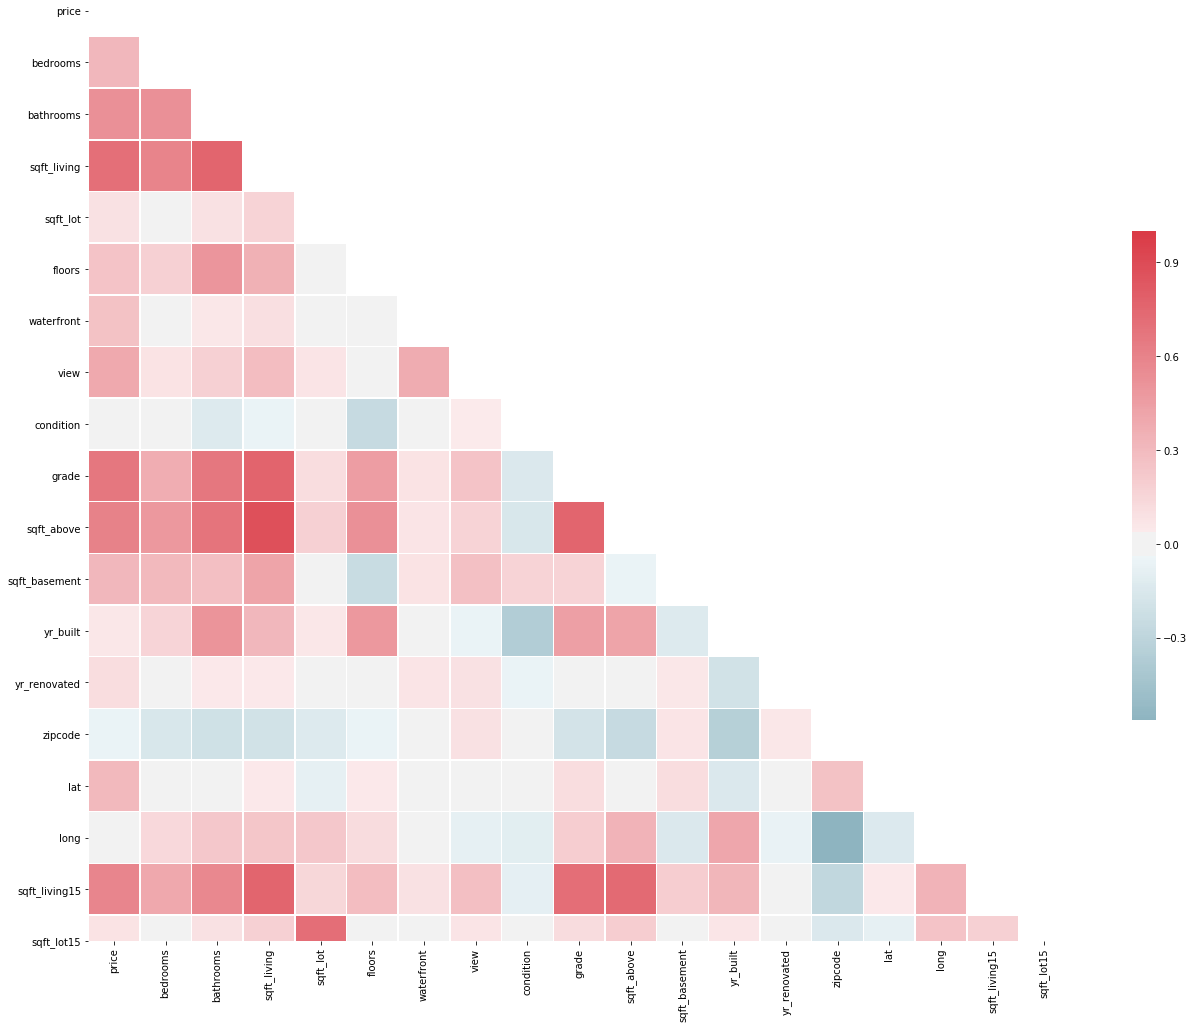

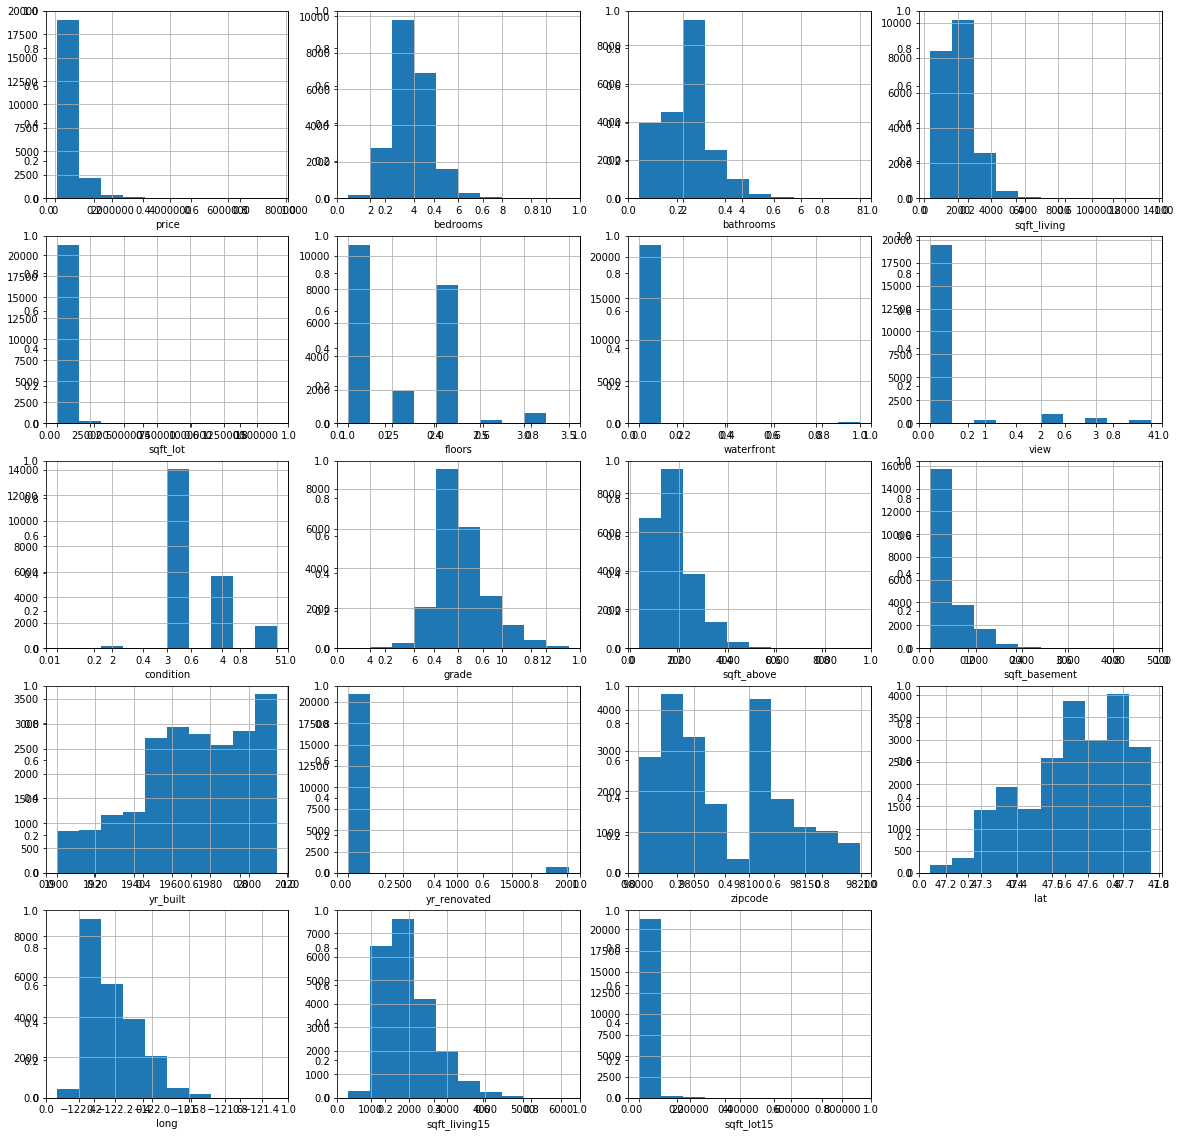

Computing most statstically significant features...
Add  floors                         with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  bathrooms                      with p-value 0.0
Drop floors                         with p-value 0.133543
Add  yr_built                       with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  view                           with p-value 0.0
Add  grade                          with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  waterfront                     with p-value 1.29672e-257
Add  bedrooms                       with p-value 7.1752e-74
Add  zipcode                        with p-value 3.15121e-42
Add  long                           with p-value 4.16508e-55
Add  condition                      with p-value 9.11738e-20
Add  sqft_above                     with p-value 1.07784e-21
Add  yr_renovated                   with p-value 1.7494e-08
Add  sqft_living15                  with p-value 3.8648e-09
Add  sqft_lot15                     with p-value 4.02144e-07
Add  sqft_basement                  with p-value 0.00766179
Add  sqft_lot                       with p-value 0.00981228
train/test-split ratio: 0.7/0.3
|X_train| = 15117, |X_test| = 6480, |y_train| = 15117, |y_test| = 6480
Train Mean Squarre

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     2120.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:42:21   Log-Likelihood:            -2.0599e+05
No. Observations:               15117   AIC:                         4.120e+05
Df Residuals:                   15099   BIC:                         4.122e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.198e+06   3.43e+06      1.515

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


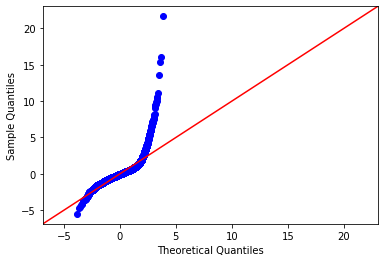

In [32]:
target = 'price'

# test-split ratio
tr = 0.3

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_renamed_cols_orig_cleaned_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_renamed_cols_orig_cleaned_df
    , sel_features
    , their_pvals
    , model
    , display_feat_regress_plots=False
)

In [33]:
display(HTML("$R^2 = {}$ is pretty good!".format(round(model_fit_results.rsquared, 3))))
display(HTML("But take a look at the difference in MSEs between our training and test partitions - note that we split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is a woeful ${}$</b>!".format(int(abs(train_mse-test_mse)))))

We MUST do some work to improve the performance of our preliminary linear regression model if we hope to predict sale price with confidence.

Note, in particular, that OLS reports that **"there are
strong multicollinearity or other numerical problems"** in the data set.

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
bedrooms,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,True,True,True,True,False,True,False,False,False,True,True,False,True,False,False,False,False,True,False
sqft_living,True,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False


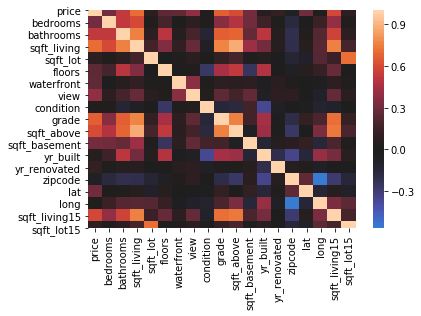

price 53.0% correlated to bathrooms
price 70.0% correlated to sqft_living
price 67.0% correlated to grade
price 61.0% correlated to sqft_above
price 59.0% correlated to sqft_living15
bedrooms 53.0% correlated to bathrooms
bedrooms 59.0% correlated to sqft_living
bathrooms 53.0% correlated to price
bathrooms 53.0% correlated to bedrooms
bathrooms 76.0% correlated to sqft_living
bathrooms 50.0% correlated to floors
bathrooms 67.0% correlated to grade
bathrooms 69.0% correlated to sqft_above
bathrooms 51.0% correlated to yr_built
bathrooms 57.0% correlated to sqft_living15
sqft_living 70.0% correlated to price
sqft_living 59.0% correlated to bedrooms
sqft_living 76.0% correlated to bathrooms
sqft_living 76.0% correlated to grade
sqft_living 88.0% correlated to sqft_above
sqft_living 76.0% correlated to sqft_living15
sqft_lot 72.0% correlated to sqft_lot15
floors 50.0% correlated to bathrooms
floors 52.0% correlated to sqft_above
grade 67.0% correlated to price
grade 67.0% correlated to ba

In [34]:
kchd_min_mc_df = kchd_renamed_cols_orig_cleaned_df.copy()
corr_threshold = 0.5
correlations, most_correlated = summarize_multicolinearity(kchd_min_mc_df, target, corr_threshold)

## Feature Scaling, Normalization, Transformation, and Categorization

### Categorical Feature "Classification"

Drawing from our observations from our original search for outliers, we see that **there are more features which are *apparently* categorical**.

Additionally, we can get a visual feel for which features are *categorical* vs *continuous* with scatter-plots of their values versus the *target feature*: **price**.

The idea is to **separate apparent *categorical* features from *continuous* features**.

In [35]:
def scatter_plots(df, target):
    # Create scatter plots
    r_w = 20
    r_h = 4

    c_n = 4
    r_n = len(df.columns)/c_n
    r_n = int(r_n) + (1 if r_n % int(r_n) != 0 else 0)

    fig = plt.figure(figsize=(r_w, r_h*r_n))

    axes = fig.subplots(r_n, c_n)

    for index, feat in enumerate(df.drop([target], axis=1)):
        ax = fig.add_subplot(r_n, c_n, index+1)
        plt.scatter(df[feat], df[target], alpha=0.2)
        plt.xlabel(feat)
        plt.ylabel(target)

    flattened_axes = axes.flatten()
    for unused in range(len(flattened_axes)-1, index, -1):
        fig.delaxes(flattened_axes[unused])

    plt.show();

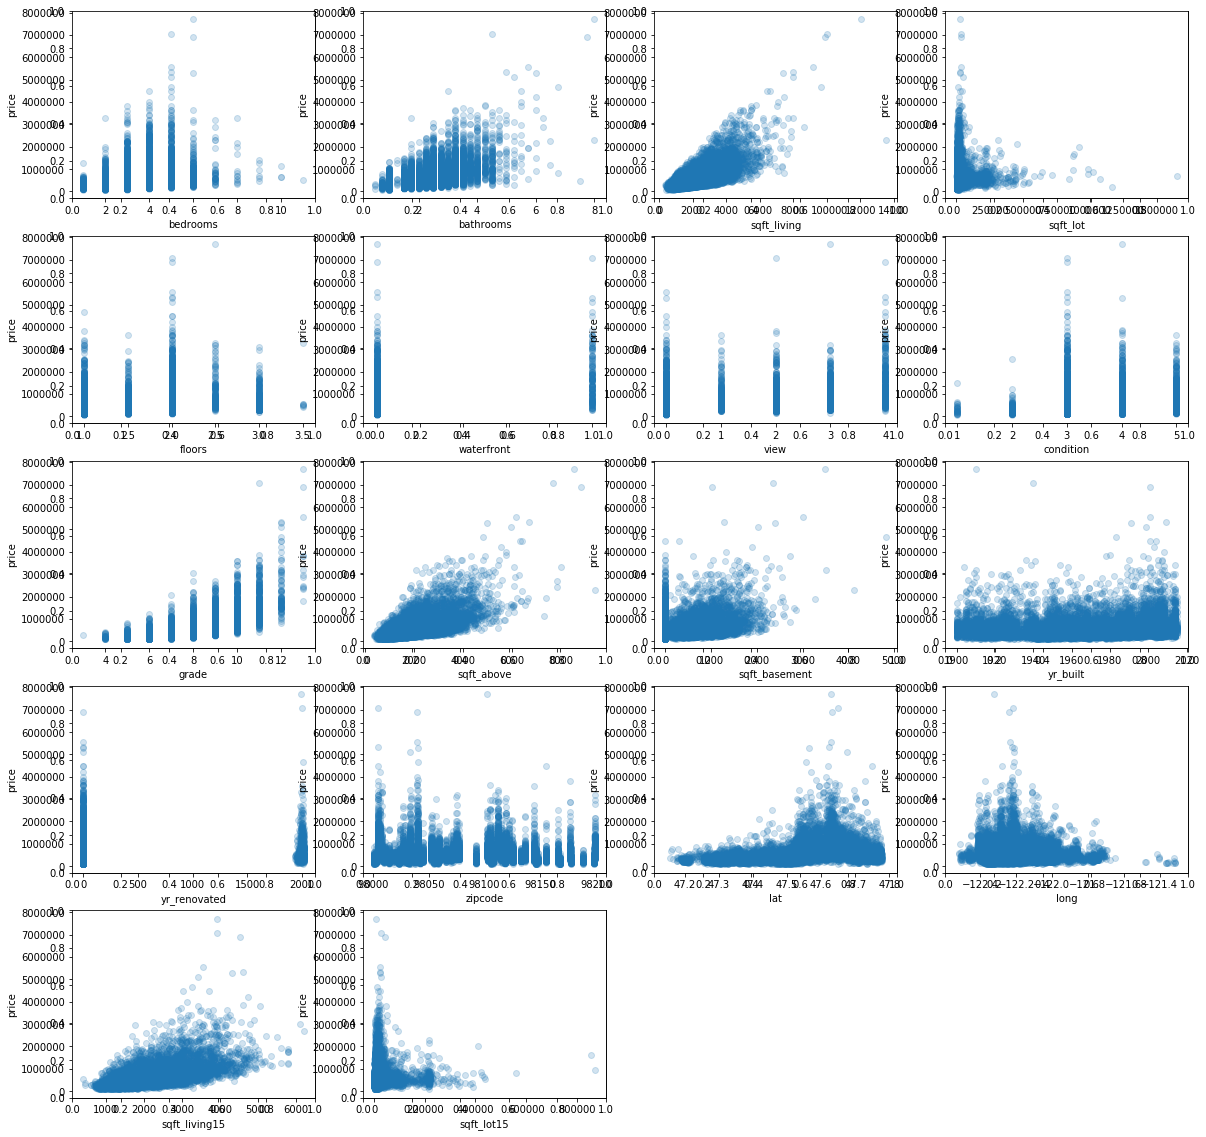

,name,index,dtype,n_unique,p_cat,unique_vals
0,bedrooms,1,int64,11,0.9995,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
1,bathrooms,2,float64,29,0.9987,"[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]"
2,floors,5,float64,6,0.9997,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]"
3,waterfront,6,float64,2,0.9999,"[0.0, 1.0]"
4,view,7,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,condition,8,int64,5,0.9998,"[1, 2, 3, 4, 5]"
6,grade,9,int64,11,0.9995,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"


In [36]:
scatter_plots(kchd_min_mc_df, target)

threshold = 0.998
kchd_cat_classification_df = classify_as_categorical(kchd_min_mc_df, threshold, False)
display(HTML("<b>Categorical Features:</b><br><br>"))
print_df(kchd_cat_classification_df)

categorical_features = list(kchd_cat_classification_df['name'])
continuous_features = list(kchd_min_mc_df.columns)
s_html = "Based on the above, it appears the following features are categorical:<br><br><ul>"
for cat_feat in categorical_features:
    continuous_features.remove(cat_feat)
    s_html += "<li><b>{}</b></li>".format(cat_feat)
s_html += "</ul>"
display(HTML(s_html))
continuous_features.remove('price')

Now that we have clearly identified and separated *continuous* vs. *categorical* features, we can take a look the ranges and distributions of *continuous* in order to determine whether they must be *tranformed* and/or *scaled*.

In [37]:
kchd_min_mc_df[continuous_features].describe().loc[['min', 'max']]

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
min,370.0,520.0,370.0,0.0,1900.0,0.0,98001.0,47.1559,-122.519,399.0,651.0
max,13540.0,1651359.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.7776,-121.315,6210.0,871200.0


Based on the ranges \[*min*, *max*\] of continuous features, it is clear that they need to be at least *scaled*.  

Let's have a look at the distributions of each for some insight into whether or not we should first *log-transform* a given feature.

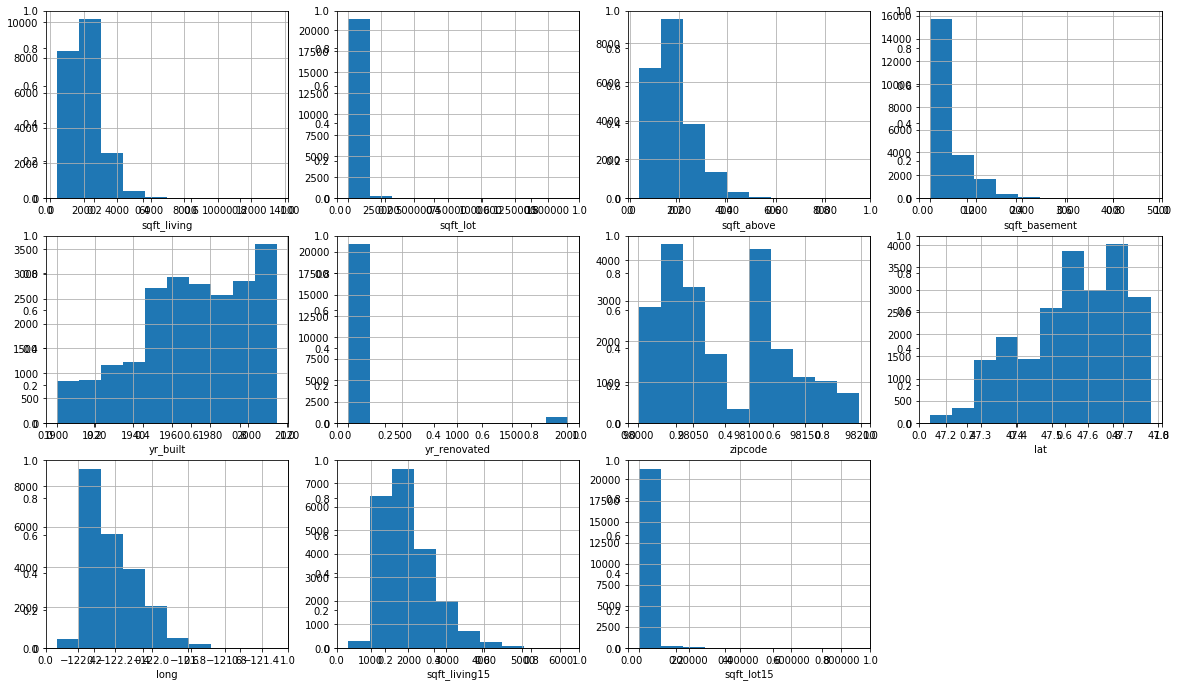

In [38]:
histograms(kchd_min_mc_df, continuous_features);

s_html = "From the distributions above, we see that <b>all <i>continuous</i> features need to be scaled</b> but <b>they must <i>first</i> be log-transformed <i>when possible</i></b> in order to push their distributions more toward normal:<br><br><ul>"
for cont_feat in continuous_features:
    s_html += "<li><b>{}</b></li>".format(cont_feat)
s_html += "</ul>"
display(HTML(s_html))

Prior to log-transforming these features, we must pay careful attention to features with values $\le 0$ and either adopt a replacement heuristic for these values to make log-transformation possible OR we can opt to simply not transform such a feature.

Note that **long** contains negative values and also that **lat** and **long** are really components of an ordered pair.  Thus, if we transform or scale one, we must do the same operation to the other.  So, in this case, we opt to skip log-transforming either, but we will *min/max scale* them.

To summarize:
1. We will do *mean normalization* of **lat** and **long**.
2. For all other continuous features, we will:
    1. replace all instances of 0.0 with 0.0001 in order to make log-transformation possible;
    2. do *min/max scaling*.

In [39]:
#log-tranformation
lt_cont_features = continuous_features.copy()
b_force_log_transform = True
if b_force_log_transform:
    for lt_cont_feature in lt_cont_features:
        clean_offending_values(
            kchd_min_mc_df
            , numeric_replacement_rules=
                {
                    lt_cont_feature: [(0.0, 0.0001)]
                }
            , friendly_name_of_df="King County House Sales DF"
        )
df_has_neg_or_0 = kchd_min_mc_df[continuous_features] <= 0.0
for ltfeat in continuous_features:
    if df_has_neg_or_0[ltfeat].sum() > 0:
        lt_cont_features.remove(ltfeat)
if 'lat' in lt_cont_features and 'long' not in lt_cont_features:
    lt_cont_features.remove('lat')
if 'long' in lt_cont_features and 'lat' not in lt_cont_features:
    lt_cont_features.remove('long')

#min-max scaling    
mm_cont_features = continuous_features
print("The following continuous features will be log-transformed:\n{}".format(lt_cont_features))
print("The following continuous features will be min-max scaled:\n{}".format(mm_cont_features))

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_living' column value replacement are: [(0.0, 0.0001)]
Looking for rows with 'sqft_living' values [0.0] ...
There are no rows that contain values of 'sqft_living' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_lot' column value replacement are: [(0.0, 0.0001)]
Looking for rows with 'sqft_lot' values [0.0] ...
There are no rows that contain values of 'sqft_lot' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_above' column value replacement are: [(0.0, 0.0001)]
Looking for rows with 'sqft_above' values [0.0] ...
There are no rows that contain values of 'sqft_above' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basemen

In [40]:
def log_transform(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        df[feat] = df[feat].map(lambda v: np.log(v))
    return df

# Min-max scaling: this will not be particularly useful to us in this case since this way of scaling brings values between 0 and 1
def min_max_scaling(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-min_feat)/(max_feat-min_feat))
    return df

# standardization does not make data  moremore  normal, it will just change the mean and the standard error!
def standardization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        sqr_var_feat = np.sqrt(np.var(df[feat]))
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/sqr_var_feat)
    return df

# The distribution will have values between -1 and 1, and a mean of 0.
def mean_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        mean_feat = df[feat].mean()
        min_feat = df[feat].min()
        max_feat = df[feat].max()
        df[feat] = df[feat].map(lambda x: (x-mean_feat)/(max_feat-min_feat))
    return df    

# Unit vector transformation
def unit_vector_normalization(df, target_features, inplace=False):
    if not inplace:
        df = df.copy(deep=True)
    for feat in target_features:
        norm_feat = np.sqrt((df[feat]**2).sum())
        df[feat] = df[feat].map(lambda x: x/norm_feat)
    return df 

In [41]:
kchd_transformed_and_scaled_df = kchd_min_mc_df

# log-transformation
kchd_transformed_and_scaled_df = log_transform(kchd_transformed_and_scaled_df, lt_cont_features)

# min-max scaling
kchd_transformed_and_scaled_df = min_max_scaling(kchd_transformed_and_scaled_df, mm_cont_features)

**Transforming and scaling our *continuous* features yields the following ranges**:

In [42]:
kchd_transformed_and_scaled_df[continuous_features].describe().loc[['min', 'max']]

,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Note that our target feature should be scaled, as well.

In [43]:
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min      78000.0
max    7700000.0
Name: price, dtype: float64

In [44]:
kchd_transformed_and_scaled_df = min_max_scaling(kchd_transformed_and_scaled_df, [target])
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min    0.0
max    1.0
Name: price, dtype: float64

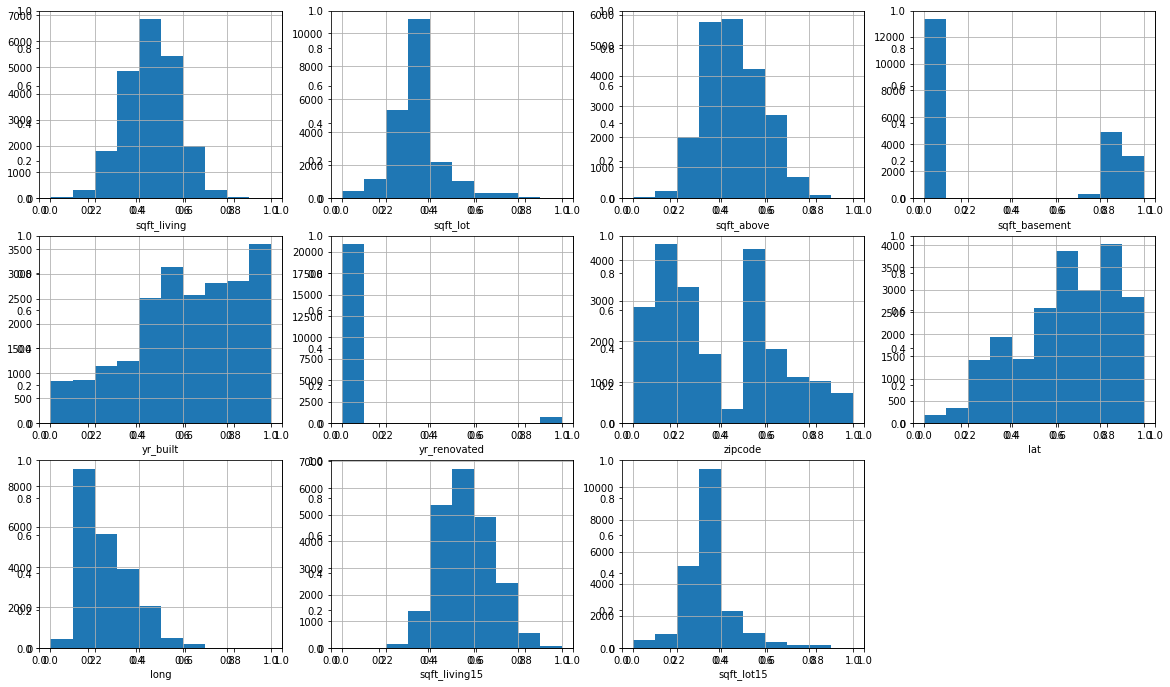

In [45]:
histograms(kchd_transformed_and_scaled_df, continuous_features);

Now that we've log-transformed and scaled our continuous features (as well as our target feature), let's build a new linear regression model and see how it performs.

Based on the observed distributions, transforming/scaling **yr_built**, **yr_renovated**, **lat**, and **long** are still quite skewed.  So we will drop those from our data set.

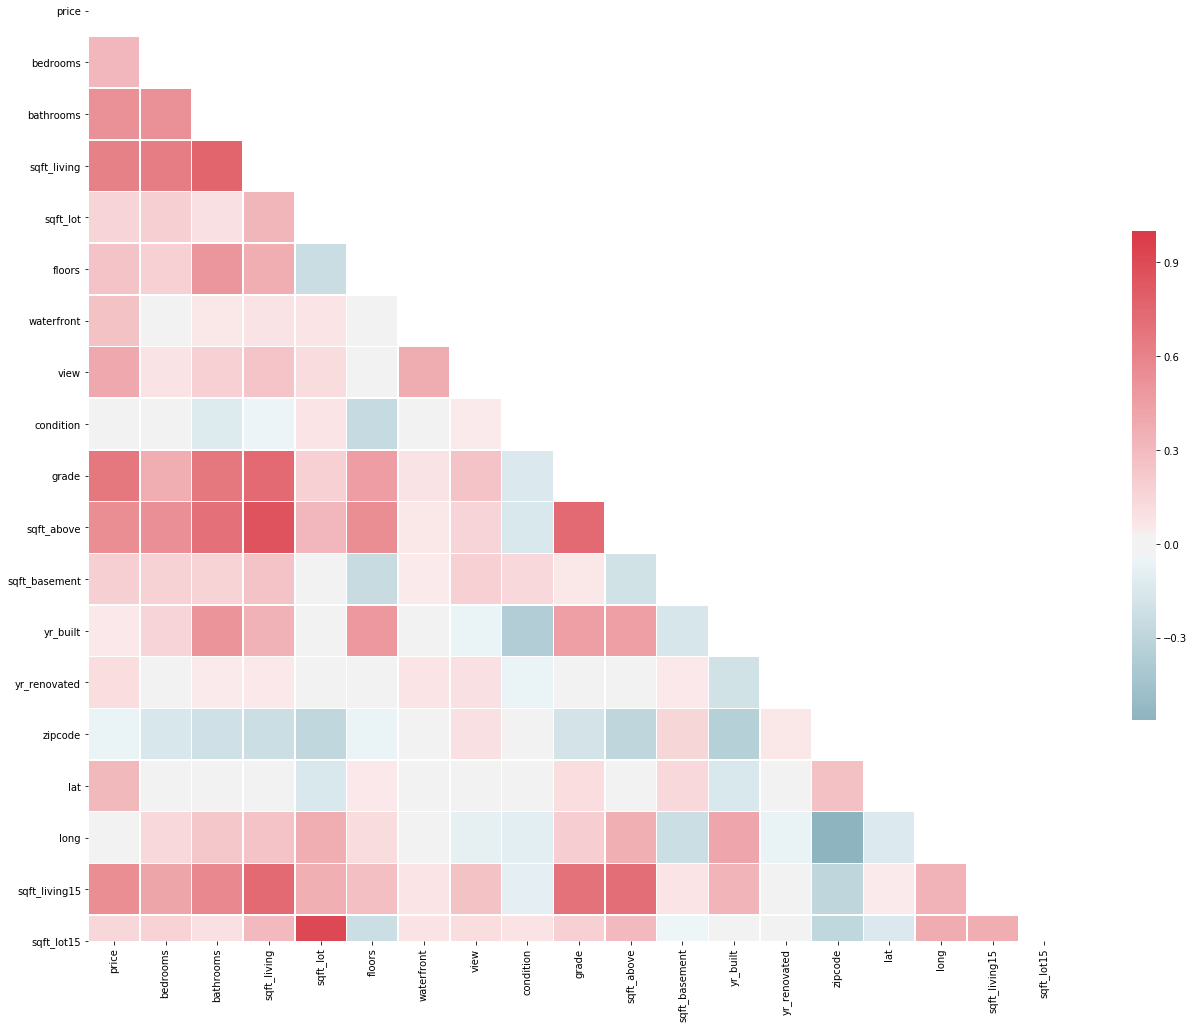

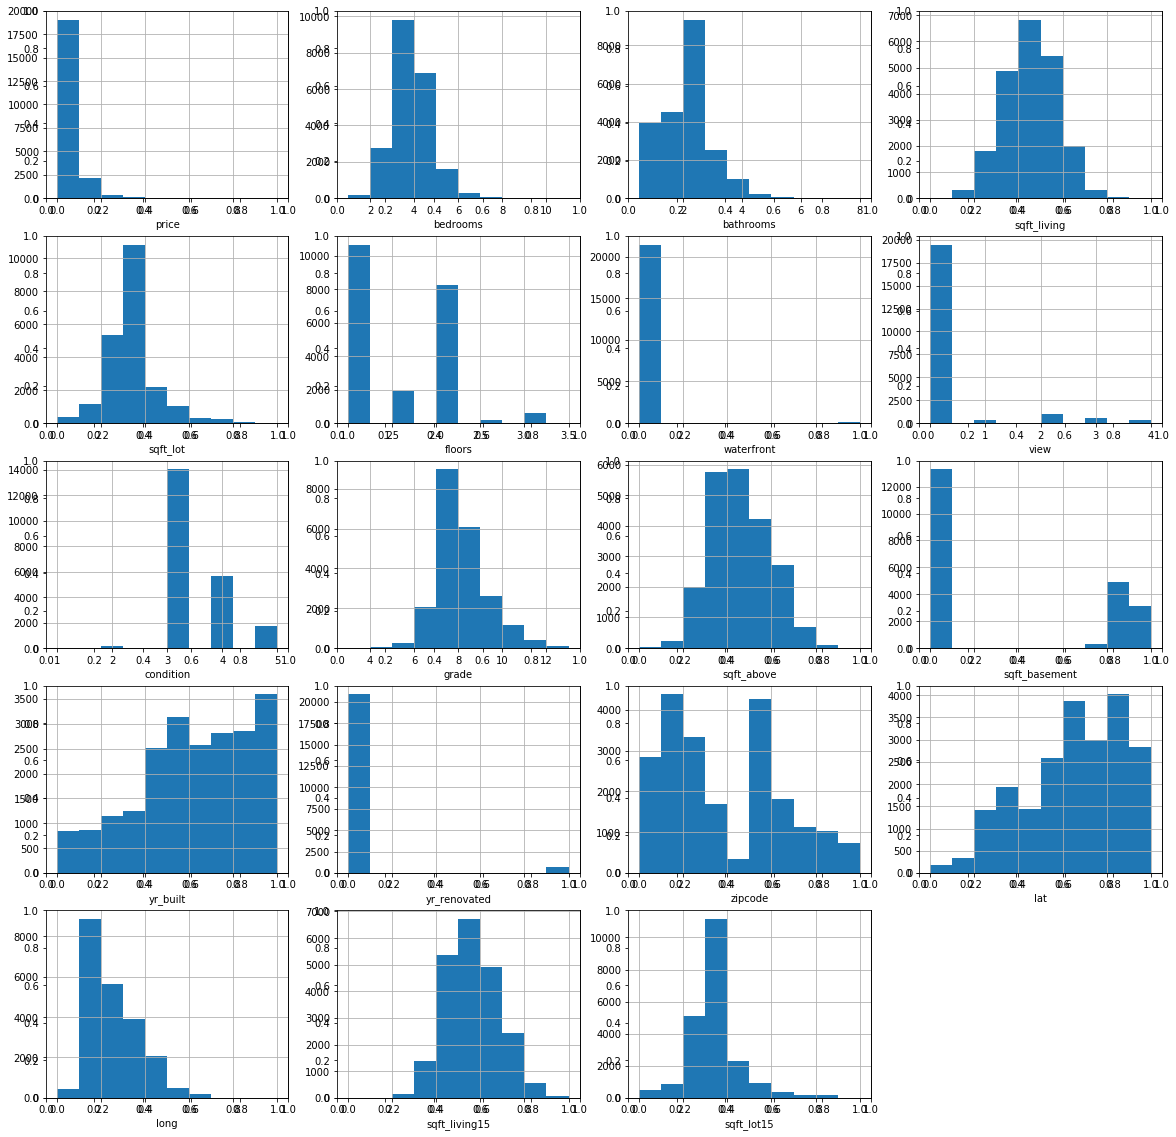

Computing most statstically significant features...
Add  floors                         with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  bathrooms                      with p-value 0.0
Drop floors                         with p-value 0.133543
Add  yr_built                       with p-value 0.0
Add  view                           with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  grade                          with p-value 0.0
Add  lat                            with p-value 0.0
Add  waterfront                     with p-value 1.14572e-236
Add  sqft_living                    with p-value 1.70095e-102
Add  zipcode                        with p-value 5.06747e-52
Add  long                           with p-value 2.79563e-19
Add  sqft_above                     with p-value 6.07835e-23
Add  sqft_basement                  with p-value 6.34294e-23
Add  condition                      with p-value 1.51955e-21
Add  sqft_living15                  with p-value 1.40077e-17
Add  bedrooms                       with p-value 2.30127e-15
Add  yr_renovated                   with p-value 4.79434e-06
train/test-split ratio: 0.7/0.3
|X_train| = 15117, |X_test| = 6480, |y_train| = 15117, |y_test| = 6480
Train Mean Squarred Error:              0.0007693407996491634
Test Mean Squarred Error:               0.0008085903308716046
delta:                                  3.9249531222441

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     2056.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:42:43   Log-Likelihood:                 32744.
No. Observations:               15117   AIC:                        -6.546e+04
Df Residuals:                   15101   BIC:                        -6.533e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1433      0.003    -54.236

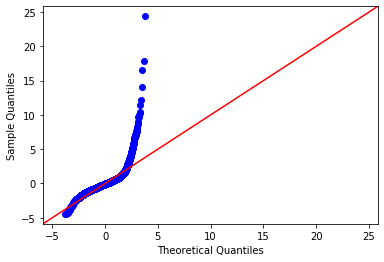

In [46]:
(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_transformed_and_scaled_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_transformed_and_scaled_df
    , sel_features
    , their_pvals
    , model
    , display_feat_regress_plots=False
)

Now, without "binning" - i.e. without officially *categorizing* - our categorical features, let's scale their ranges if necessary, with the intent to produce a better performing (than preliminary) linear regression model.

In [47]:
threshold = 0.0
kchd_cat_classification_df = classify_as_categorical(kchd_transformed_and_scaled_df[categorical_features], threshold, False)
display(HTML("<b>Categorical Features:</b><br><br>"))
print_df(kchd_cat_classification_df)

print_df(kchd_transformed_and_scaled_df[categorical_features].describe().loc[['min', 'max']])

,name,index,dtype,n_unique,p_cat,unique_vals
0,bedrooms,0,int64,11,0.9995,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
1,bathrooms,1,float64,29,0.9987,"[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0]"
2,floors,2,float64,6,0.9997,"[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]"
3,waterfront,3,float64,2,0.9999,"[0.0, 1.0]"
4,view,4,float64,5,0.9998,"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,condition,5,int64,5,0.9998,"[1, 2, 3, 4, 5]"
6,grade,6,int64,11,0.9995,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]"


,bedrooms,bathrooms,floors,waterfront,view,condition,grade
min,1.0,0.5,1.0,0.0,0.0,1.0,3.0
max,11.0,8.0,3.5,1.0,4.0,5.0,13.0


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
bedrooms,False,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
bathrooms,True,True,True,True,False,True,False,False,False,True,True,False,True,False,False,False,False,True,False
sqft_living,True,True,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,True,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False


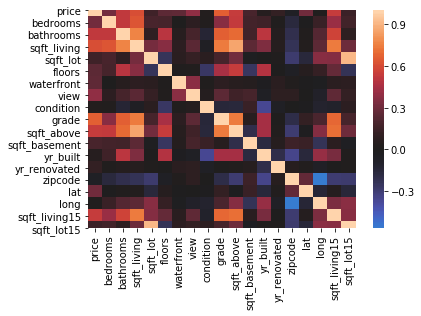

price 53.0% correlated to bathrooms
price 61.0% correlated to sqft_living
price 67.0% correlated to grade
price 54.0% correlated to sqft_above
price 54.0% correlated to sqft_living15
bedrooms 53.0% correlated to bathrooms
bedrooms 64.0% correlated to sqft_living
bedrooms 53.0% correlated to sqft_above
bathrooms 53.0% correlated to price
bathrooms 53.0% correlated to bedrooms
bathrooms 76.0% correlated to sqft_living
bathrooms 50.0% correlated to floors
bathrooms 67.0% correlated to grade
bathrooms 70.0% correlated to sqft_above
bathrooms 51.0% correlated to yr_built
bathrooms 57.0% correlated to sqft_living15
sqft_living 61.0% correlated to price
sqft_living 64.0% correlated to bedrooms
sqft_living 76.0% correlated to bathrooms
sqft_living 74.0% correlated to grade
sqft_living 86.0% correlated to sqft_above
sqft_living 75.0% correlated to sqft_living15
sqft_lot 92.0% correlated to sqft_lot15
floors 50.0% correlated to bathrooms
floors 55.0% correlated to sqft_above
grade 67.0% correlat

In [48]:
mc_summary = summarize_multicolinearity(kchd_transformed_and_scaled_df, target, corr_threshold)

In [49]:
display(HTML("$R^2 = {}$ after transforming and scaling is BETTER!".format(round(model_fit_results.rsquared, 3))))
display(HTML("Let's again take look at the difference in MSEs between our training and test partitions in order to evaluate the performance of the modified model - note that we again split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is superb: ${}$</b>!".format(abs(train_mse-test_mse))))

But can we do better?

Let us now *bin* our categorical data to see if it makes a difference on the performance of linear regression.

### Categorization/Binning

From the above, we note that:
- **bathrooms** has a strange range of values, \[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0\], but we can handle this by appropriate binning into:
    - $16$ bins: [0, 0.5), [0.5, 1), [1, 1.5), [1.5, 2), [2, 2.5), [2.5, 3), [3, 3.5), [3.5, 4), [4, 4.5), [4.5, 5), [5, 5.5), [5.5, 6), [6, 6.5), [6.5, 7), [7, 7.5), [7.5, 8)
    - we bin in increments of 0.5 since, according to the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) in this data set, **bathrooms** is "Number of bathrooms, where .5 accounts for a room with a toilet but not shower"
- for all other categorical features from the list above, since the count of categorical values is low, we simply create partitions according to the *cardinality* of the set of categorical values of each

Note:<br>
For the **bathrooms** categorical feature, we could have addressed the values with 0.25 and 0.75 components in the cleaning phase via a *rounding* replacement heuristic but then we would have had to decide whether either should round up or down, to the nearest 0.5 increment.  *Binning* effectively accomplishes the same and with less work (since we have to do binning anyway).  Additionally, by binning in increments of 0.5, we adhere close to the definition of **bathrooms** listed in the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices).  **We are interested in observing the impact that adding additional bathrooms *with and without a shower* has on potential sale price**.

In [50]:
def partition(df, feature, bins=None):
    if bins is None:
        bins = list(df[feature].unique())
    bins.append(min(bins)-1)
    bins = sorted(bins)
    #print("{} bins list: {}".format(feature, bins))
    bins_feature = pd.cut(df[feature], bins)
    bins_feature = bins_feature.cat.as_unordered()
    #print("{} bins:\n{}".format(feature, bins_feature))
    return bins_feature

def categorize(df, feature, bins=None):
    bins_feature = partition(df, feature, bins)
    feature_dummy = pd.get_dummies(bins_feature, prefix=feature, drop_first=True)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, feature_dummy], axis=1)
    return df

In [51]:
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_and_scaled_df, 'bedrooms')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'bathrooms', [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'floors', [1, 2, 3, 4])
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'waterfront')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'view')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'condition')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'grade')

## Linear Regression Feature Selection

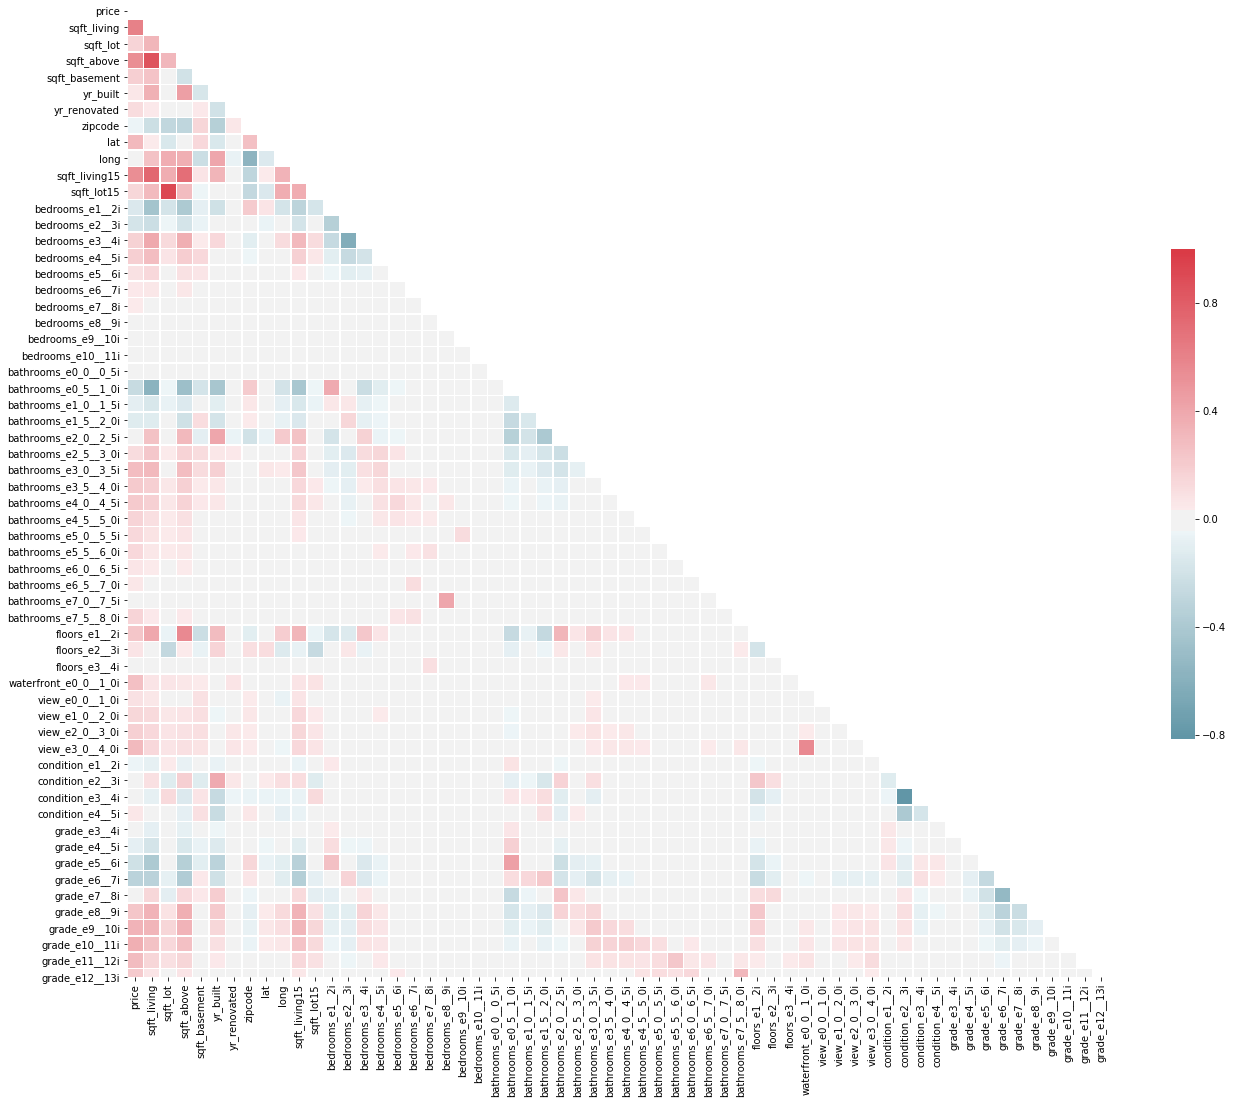

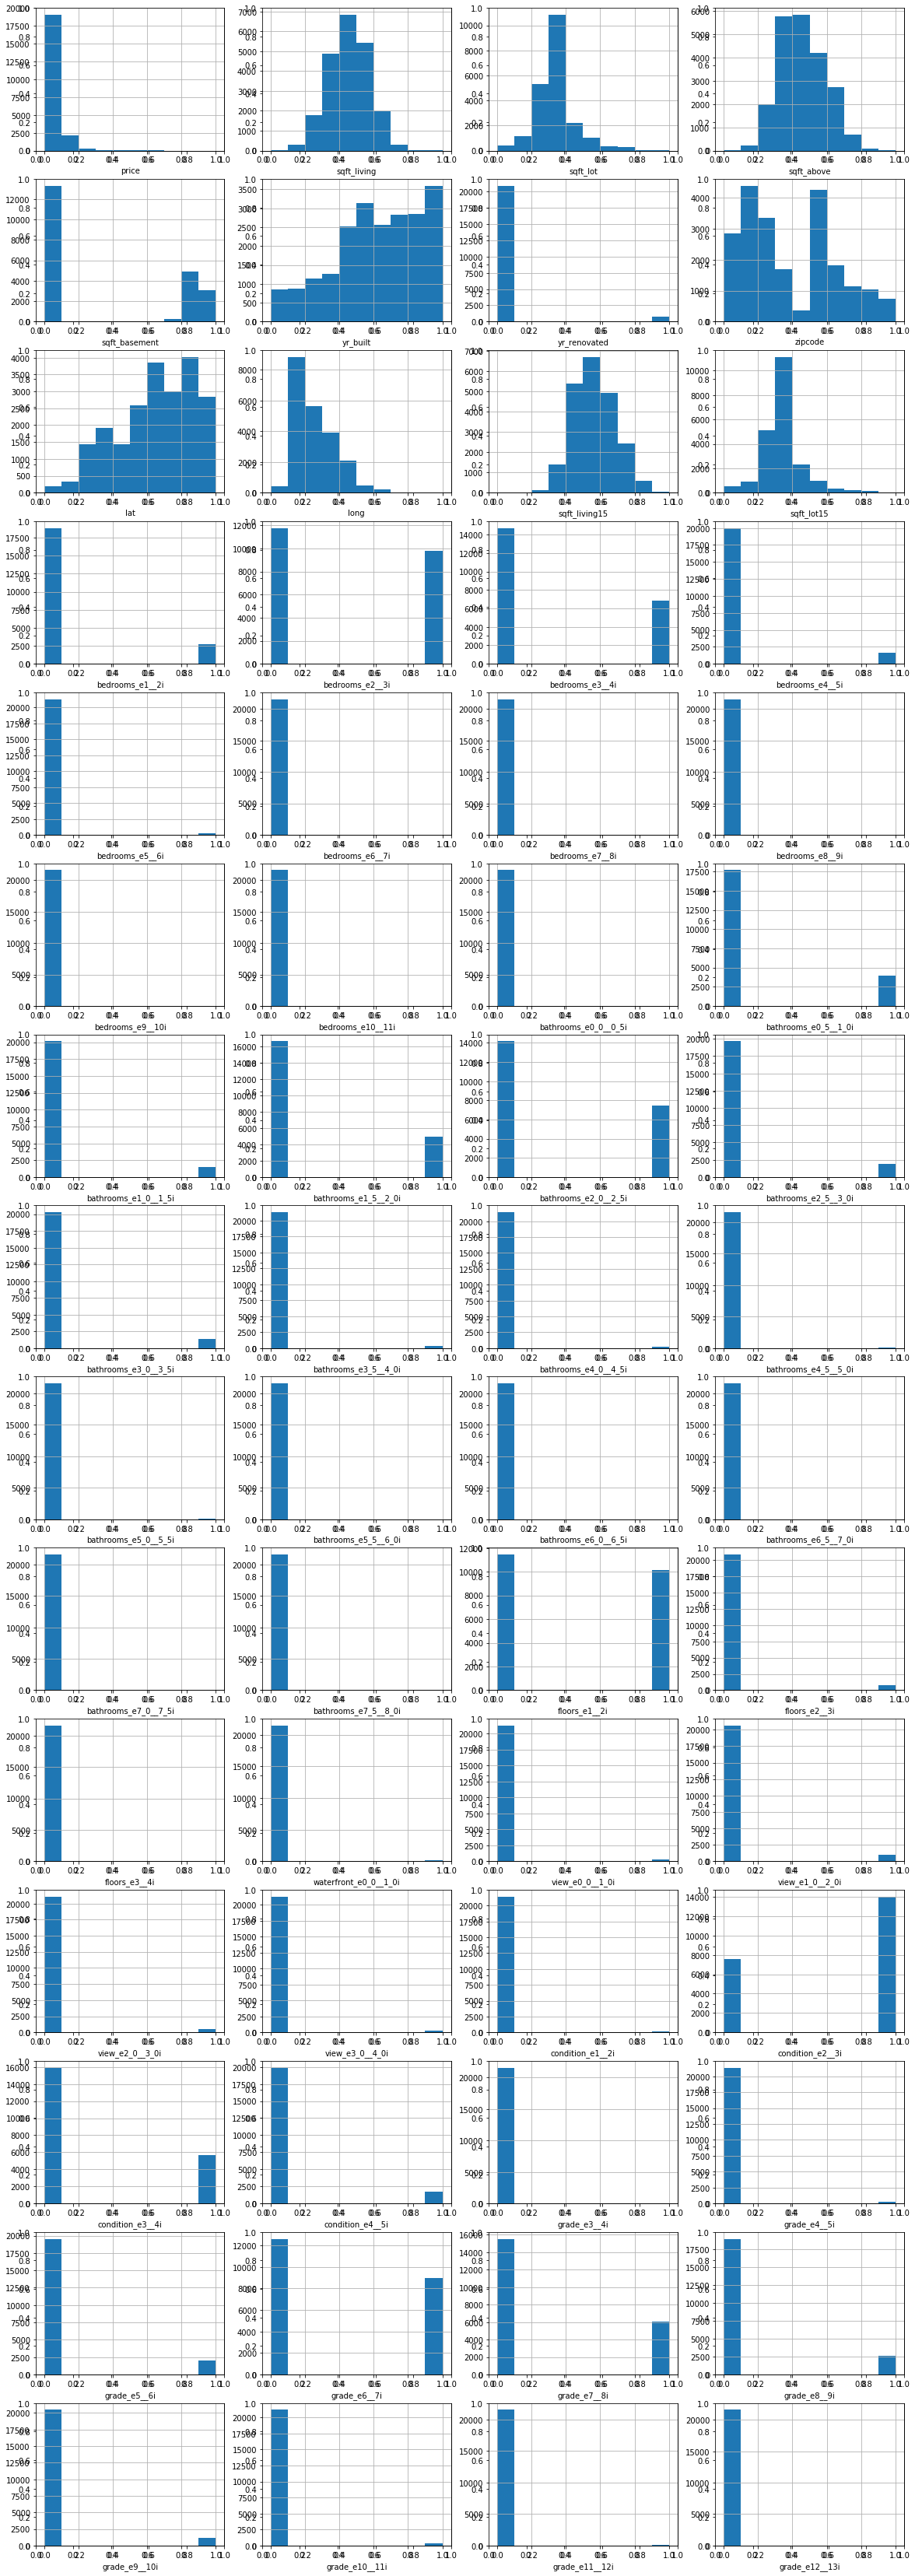

Computing most statstically significant features...


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  view_e3_0__4_0i                with p-value 0.0
Add  grade_e6__7i                   with p-value 0.0
Add  grade_e11__12i                 with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  grade_e10__11i                 with p-value 0.0
Add  lat                            with p-value 0.0
Add  grade_e12__13i                 with p-value 3.79745e-306
Add  grade_e9__10i                  with p-value 0.0
Add  grade_e8__9i                   with p-value 2.56877e-212
Add  waterfront_e0_0__1_0i          with p-value 3.55371e-179
Add  grade_e7__8i                   with p-value 3.85766e-105
Add  bathrooms_e7_5__8_0i           with p-value 6.81858e-81
Add  view_e2_0__3_0i                with p-value 1.55271e-54
Add  condition_e4__5i               with p-value 2.06156e-40
Add  zipcode                        with p-value 1.2982e-38
Add  long                       

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1138.
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:44:14   Log-Likelihood:                 34708.
No. Observations:               15117   AIC:                        -6.934e+04
Df Residuals:                   15077   BIC:                        -6.903e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.02

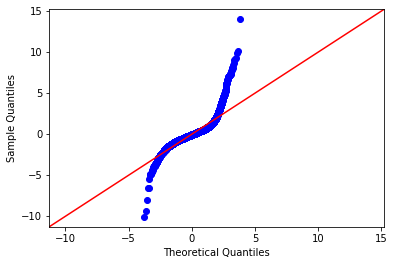

In [52]:
tf = [target]
kchd_transformed_caled_and_categorized_df = encode_col_names(kchd_transformed_caled_and_categorized_df)

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_transformed_caled_and_categorized_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_transformed_caled_and_categorized_df
    , sel_features
    , their_pvals
    , model
    , display_feat_regress_plots=False
)

['sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'yr_built', 'long', 'lat']


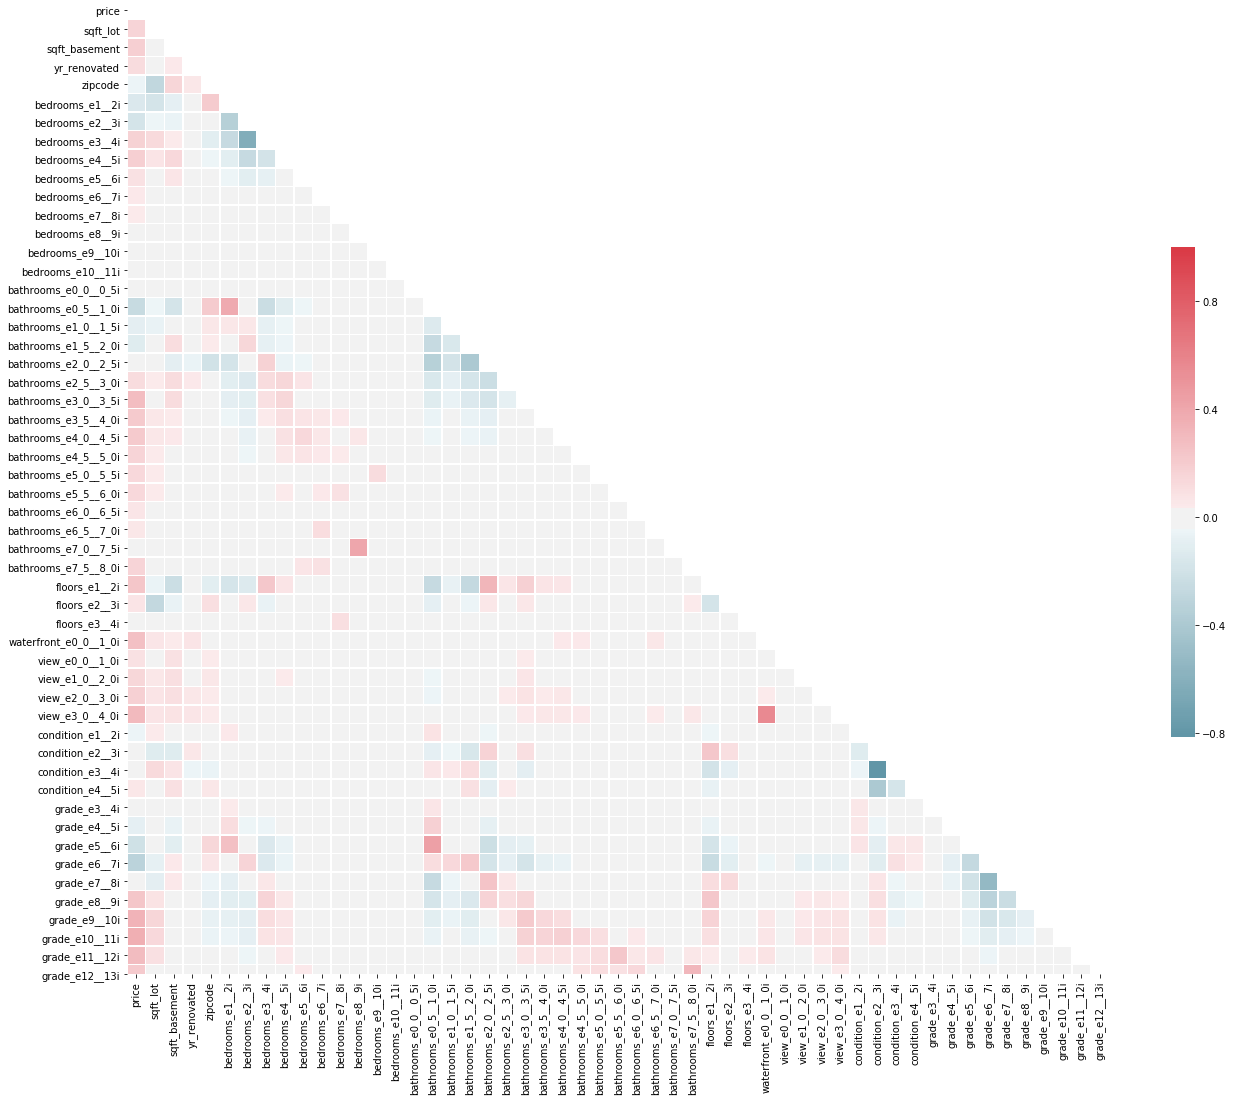

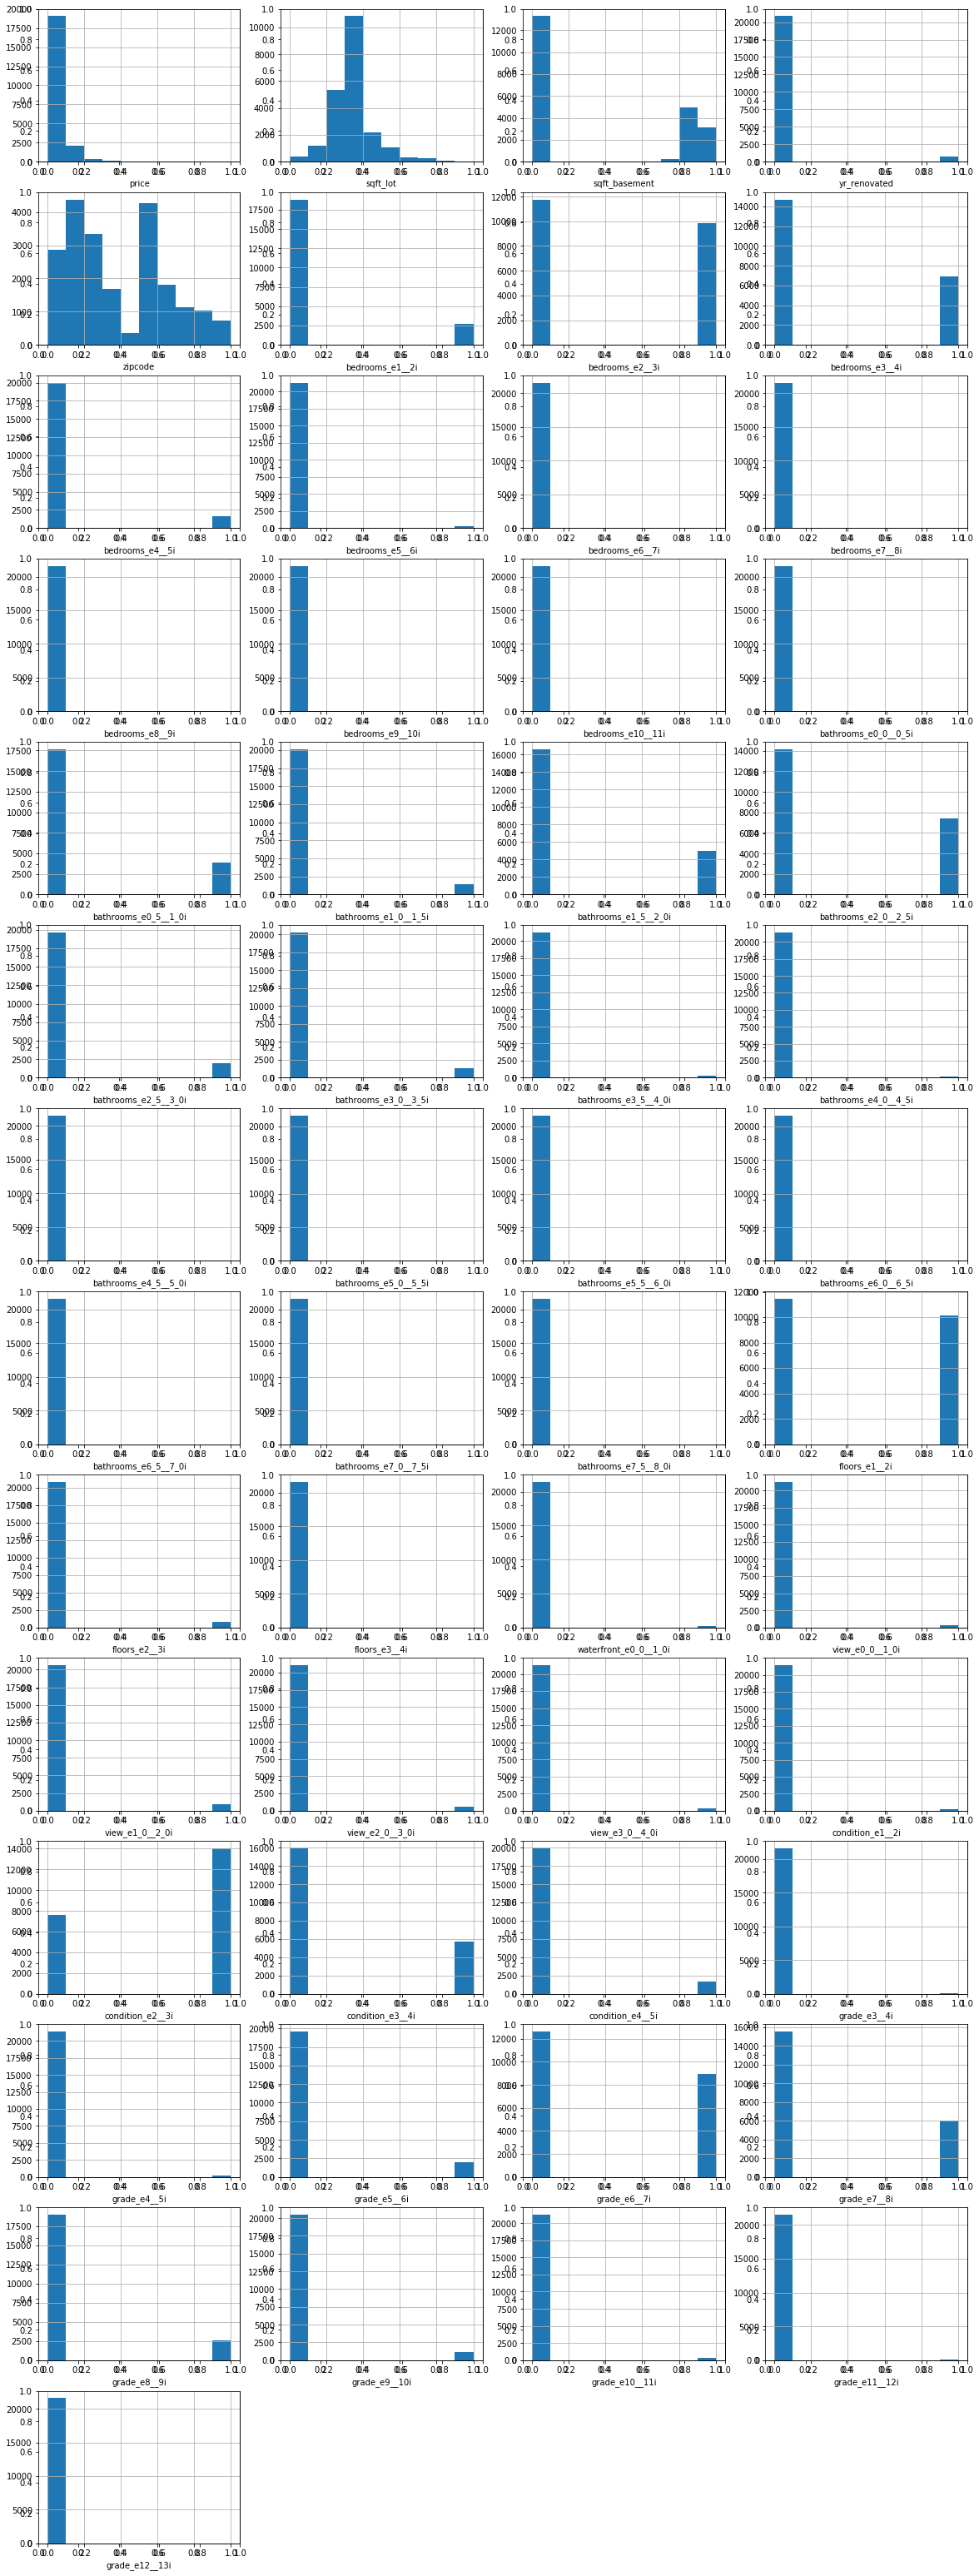

Computing most statstically significant features...


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  view_e3_0__4_0i                with p-value 0.0
Add  grade_e6__7i                   with p-value 0.0
Add  grade_e11__12i                 with p-value 0.0
Add  grade_e5__6i                   with p-value 0.0
Add  grade_e7__8i                   with p-value 0.0
Add  grade_e10__11i                 with p-value 0.0
Add  grade_e12__13i                 with p-value 0.0
Add  grade_e9__10i                  with p-value 1.09448e-296
Add  sqft_basement                  with p-value 2.09073e-256
Add  grade_e8__9i                   with p-value 4.59863e-219
Add  waterfront_e0_0__1_0i          with p-value 1.27957e-137
Add  condition_e4__5i               with p-value 5.84674e-90
Add  yr_renovated                   with p-value 1.942e-90
Add  bathrooms_e7_5__8_0i           with p-value 4.53688e-71
Add  condition_e3__4i               with p-value 4.64345e-52
Add  bedrooms_e4__5i                with p-value 1.54056e-48
Add  view_e2_0__3_0i                with p-value 4.30236e-42
Add  bathrooms_e4

/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     897.0
Date:                Tue, 12 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:45:20   Log-Likelihood:                 32545.
No. Observations:               15117   AIC:                        -6.502e+04
Df Residuals:                   15083   BIC:                        -6.476e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.01

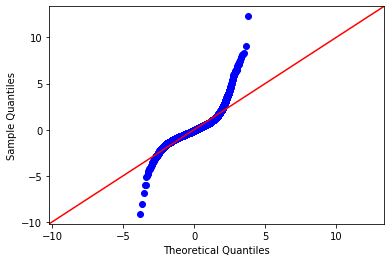

In [53]:
to_drop = list(map(lambda feat_vif: feat_vif[0], bad_vif_features))
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_df.drop(to_drop, axis=1)

kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_and_scaled_df, 'bedrooms')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'bathrooms', [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'floors', [1, 2, 3, 4])
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'waterfront')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'view')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'condition')
kchd_transformed_caled_and_categorized_df = categorize(kchd_transformed_caled_and_categorized_df, 'grade')

tf = [target]
kchd_transformed_caled_and_categorized_df = encode_col_names(kchd_transformed_caled_and_categorized_df)

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = lin_reg_model_from_auto_selected_features(kchd_transformed_caled_and_categorized_df, target, tr=tr)

(model_fit_results, good_vif_features, bad_vif_features) = model_fit_summary(
    kchd_transformed_caled_and_categorized_df
    , sel_features
    , their_pvals
    , model
    , display_feat_regress_plots=False
)

# References

Pawan, S. (2017). Predicting King County House Prices. Presentation, https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices.